In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Embedded Method

In [2]:
# Plot correlation matrix
def correlation_matrix_plot(df, asset):
    correlation_matrix = df.select_dtypes(include=['int64', 'float64']).corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='viridis', linewidths=0.9, fmt=".2f")
    plt.title(f'Correlation Matrix of {asset}')
    plt.tight_layout()
    plt.show()

In [3]:
# Feature Selection Pipeline
def select_features_rf(df, asset_name="Asset"):
    """
    Performs feature selection using a Random Forest regressor to extract feature importances for a given asset's DataFrame.

    Required Features: All features of the asset and performs additional engineering (e.g., moving averages).
    Parameters:
        df (pd.DataFrame): The input DataFrame for the asset.
        asset_name (str): Identifier for plotting and output.

    Returns:
        feat_importances (pd.Series): Feature importances sorted in descending order.
    """
    # 1. Preprocessing and Feature Engineering
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date').reset_index(drop=True)


    # Add indicators that improve models to predict better (e.g., 20-day and 50-day moving averages)
    
    # df['MA_20'] = df['Close'].rolling(window=20, min_periods=1).mean()
    # df['MA_50'] = df['Close'].rolling(window=50, min_periods=1).mean()
    # df['52W_High'] = df['High'].rolling(window=252, min_periods=1).max()
    # df['52W_Low'] = df['Low'].rolling(window=252, min_periods=1).min()

    # Plot correlation matrix
    # correlation_matrix_plot(df, asset_name)

    # Define feature columns and target variable
    features = ['Momentum_Indicator', 'High_Low_Change', 'High_Open_Change', 'Low_Open_Change']
    target = 'Close'

    new_df = df.dropna()
    X = new_df[features]
    y = new_df[target]


    # 2. Train a Random Forest Regressor
    rf = RandomForestRegressor(n_estimators=100, random_state=123)
    rf.fit(X, y)


    # 3. Extract and Plot Feature Importances
    importances = rf.feature_importances_
    feat_importances = pd.Series(importances, index=features).sort_values(ascending=False)

    print(f"\n{asset_name} - Feature Importances:")
    print(feat_importances)


    # 4. Plot feature importances as a bar chart
    plt.figure(figsize=(12, 6))
    ax = feat_importances.plot(kind='bar', title=f'Feature Importances - {asset_name}')
    plt.ylabel('Importance Score')
    plt.xticks(rotation=90)

    # Add rounded importance values as labels on bars
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.2f}", 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='bottom', fontsize=8, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Plot correlation matrix
    correlation_matrix_plot(pd.concat([X, y], axis=1), asset_name)

    return feat_importances

### Feature Selection for Indexes

### Feature Selection for Each Index ###

Processing Index: NSEI

Index: NSEI - Feature Importances:
High_Low_Change       0.356268
Momentum_Indicator    0.239036
High_Open_Change      0.202598
Low_Open_Change       0.202097
dtype: float64


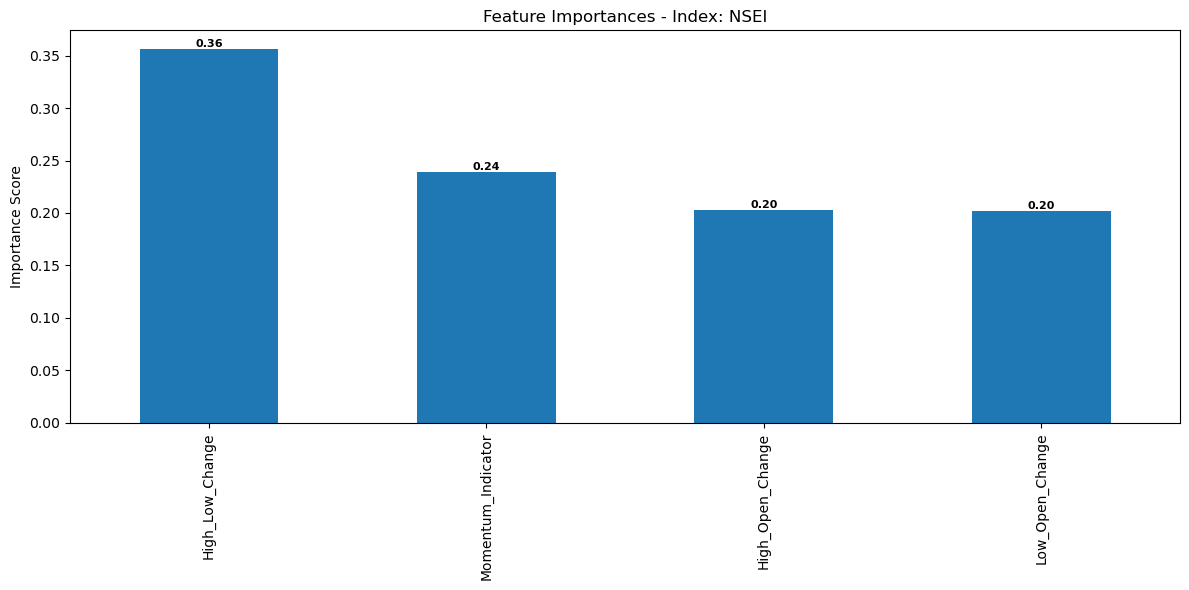

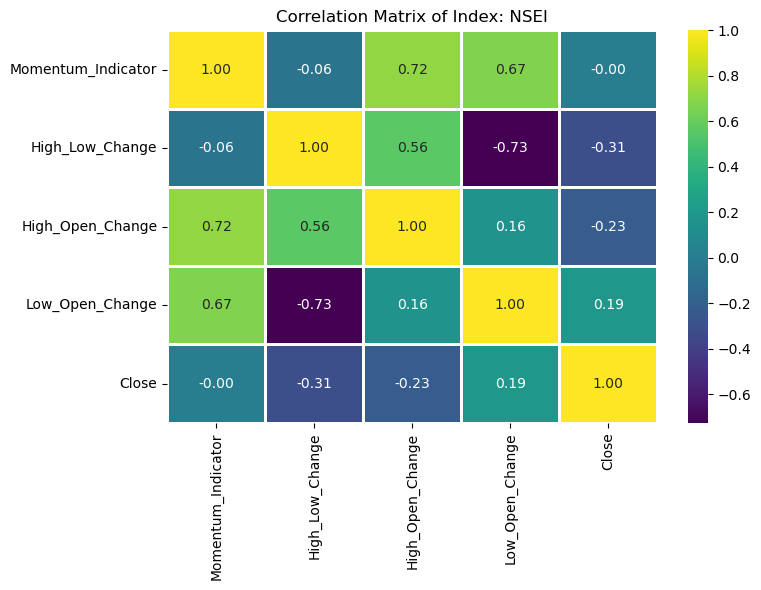


Processing Index: NSEBANK

Index: NSEBANK - Feature Importances:
High_Low_Change       0.385122
Momentum_Indicator    0.224839
Low_Open_Change       0.201157
High_Open_Change      0.188881
dtype: float64


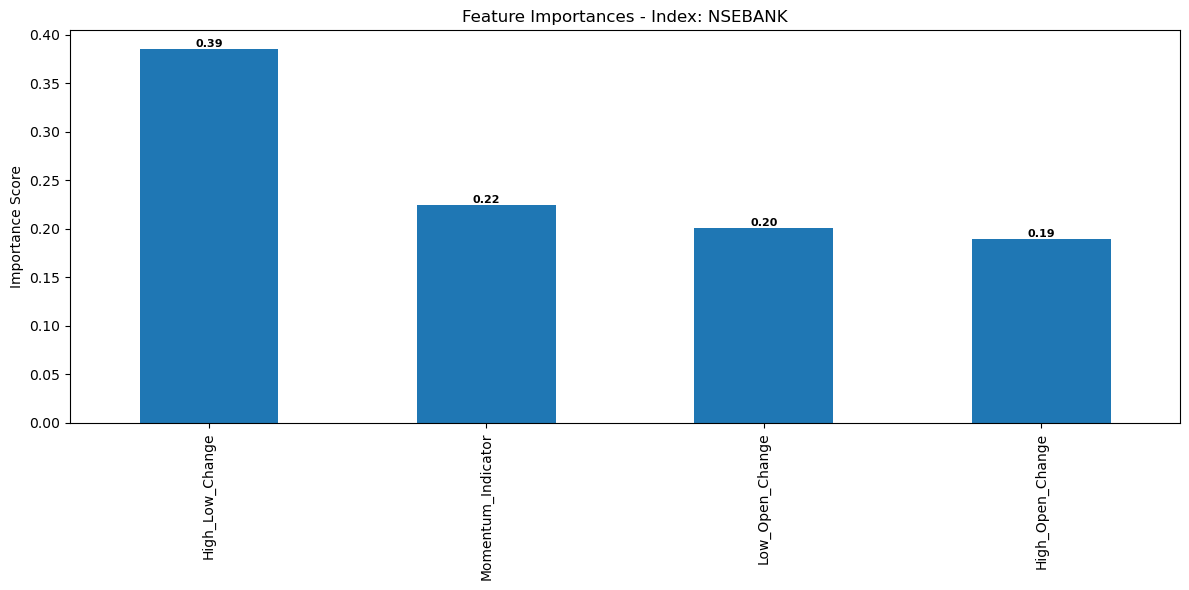

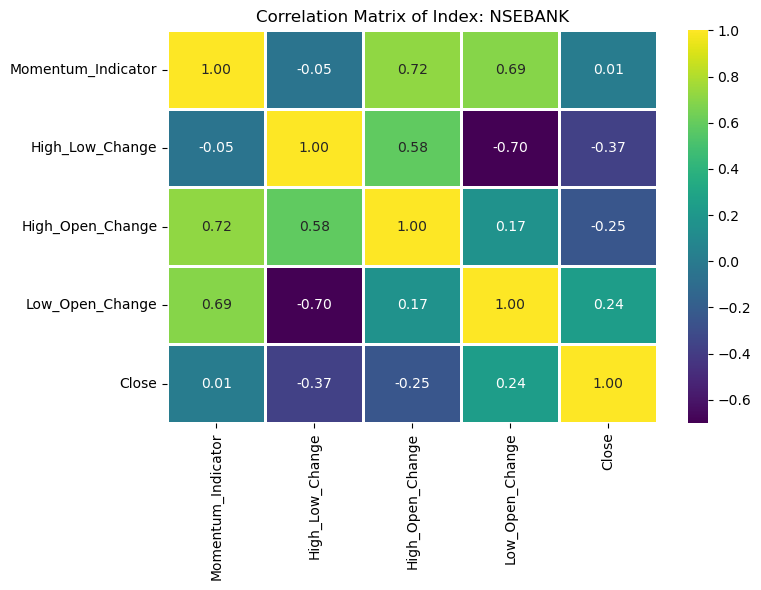


Processing Index: CNXIT

Index: CNXIT - Feature Importances:
Momentum_Indicator    0.274680
High_Low_Change       0.259660
Low_Open_Change       0.243134
High_Open_Change      0.222526
dtype: float64


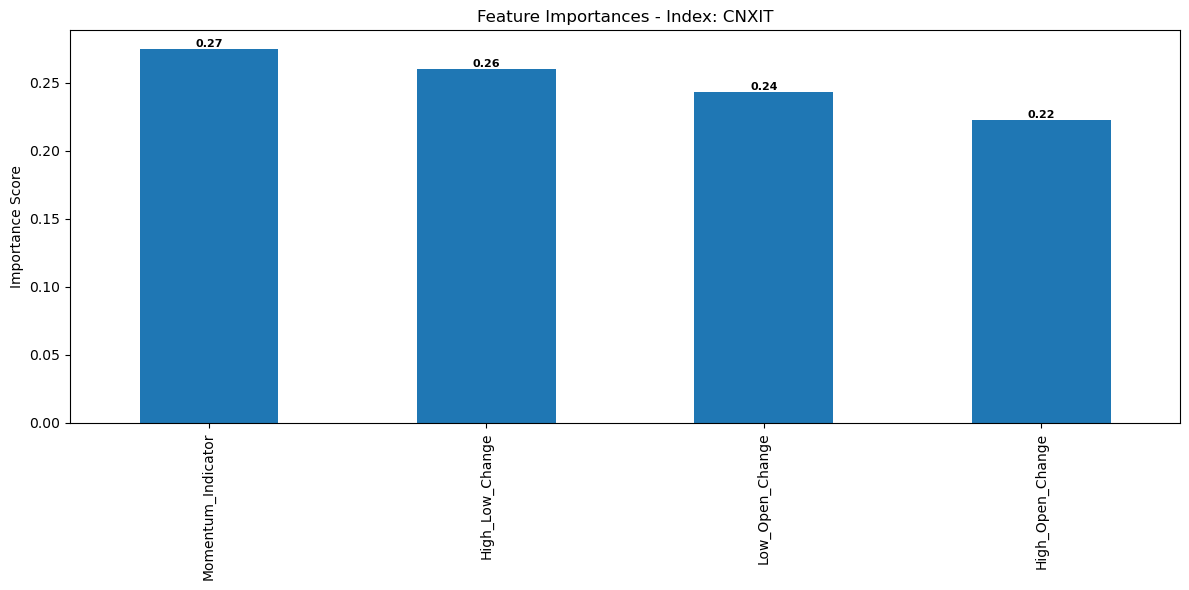

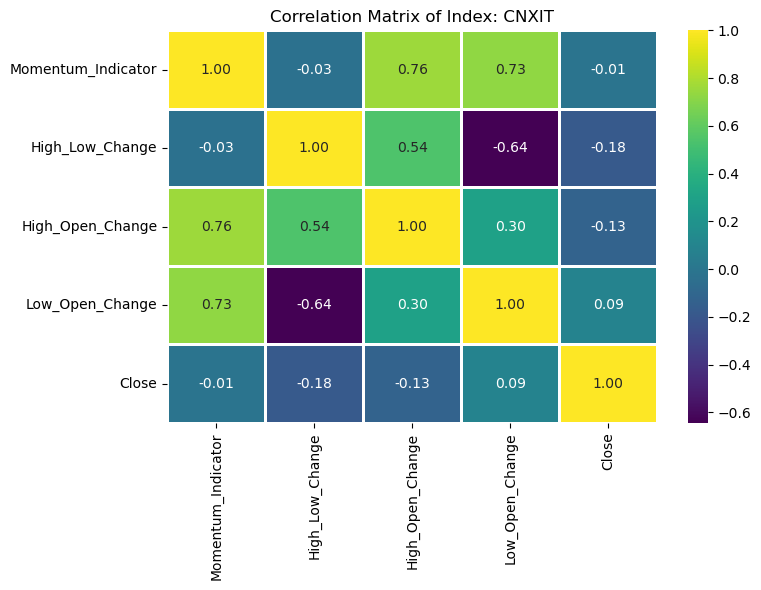


Processing Index: BSESN

Index: BSESN - Feature Importances:
High_Low_Change       0.371611
Momentum_Indicator    0.239820
High_Open_Change      0.194329
Low_Open_Change       0.194239
dtype: float64


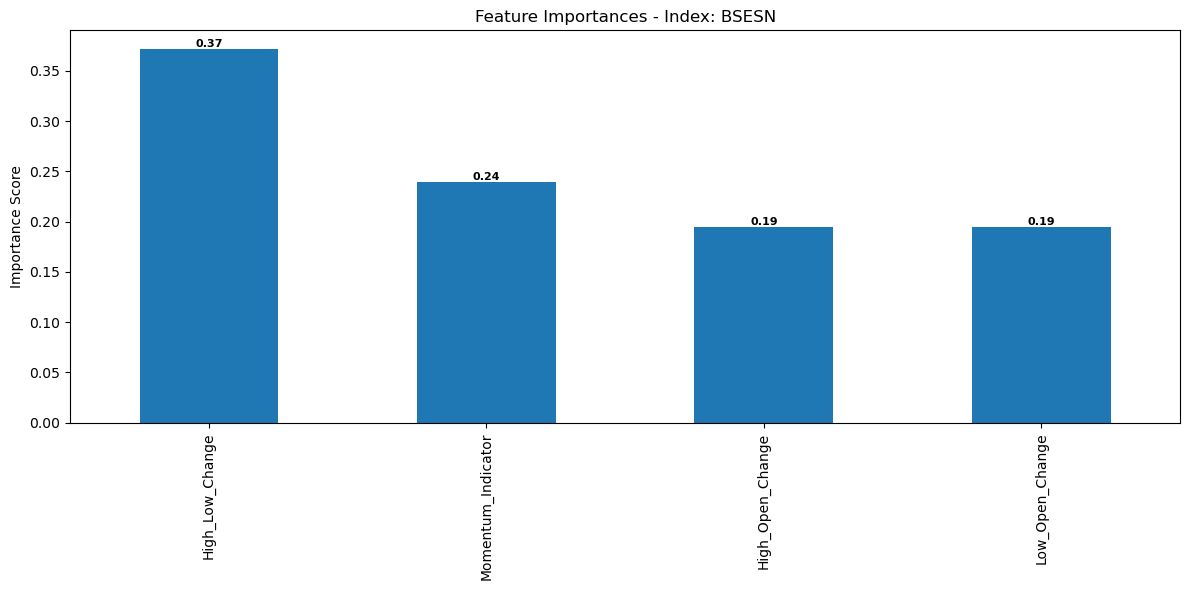

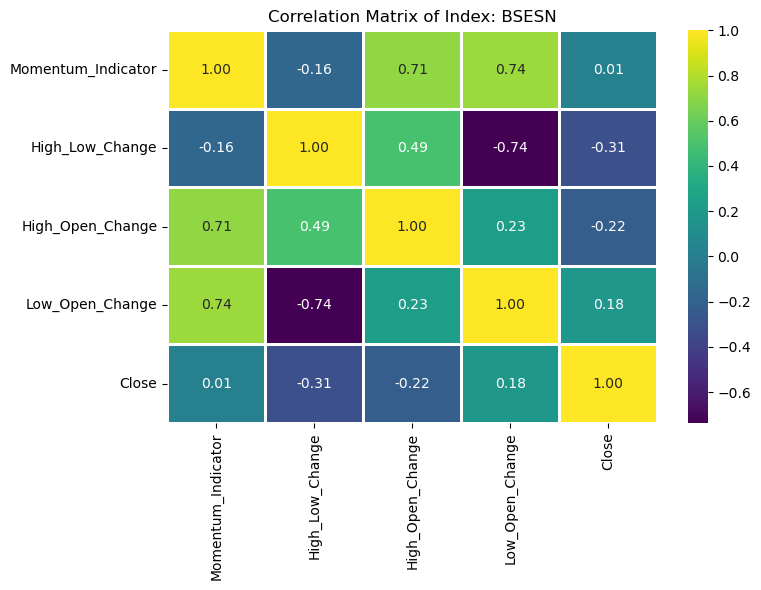


Processing Index: NIFTY_MIDCAP_100

Index: NIFTY_MIDCAP_100 - Feature Importances:
High_Open_Change      0.266757
Momentum_Indicator    0.266322
Low_Open_Change       0.247620
High_Low_Change       0.219301
dtype: float64


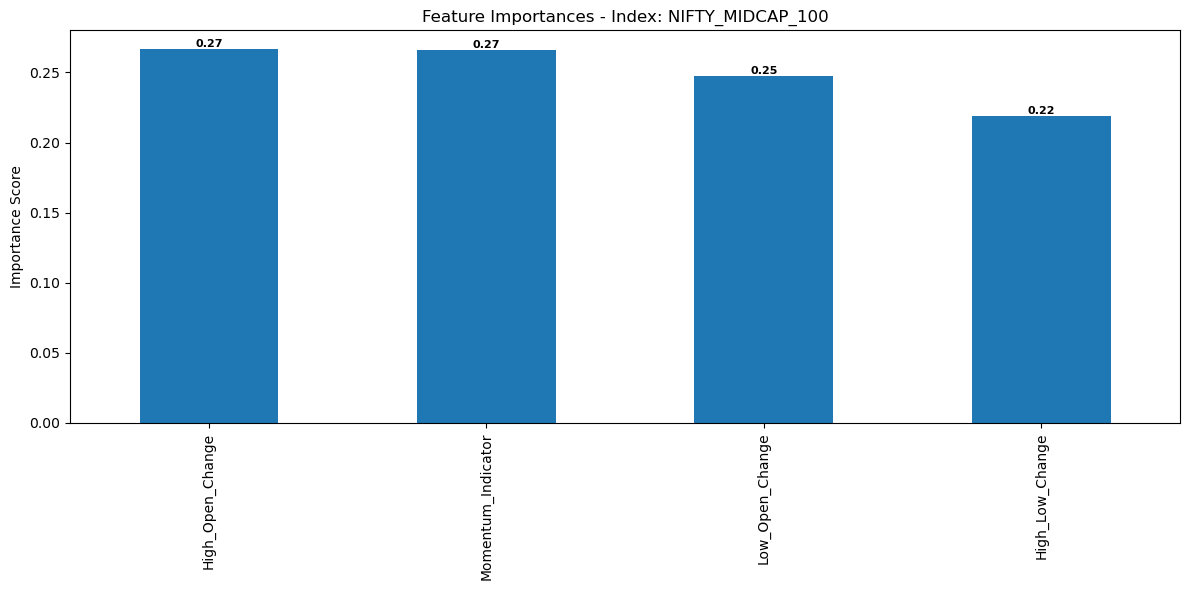

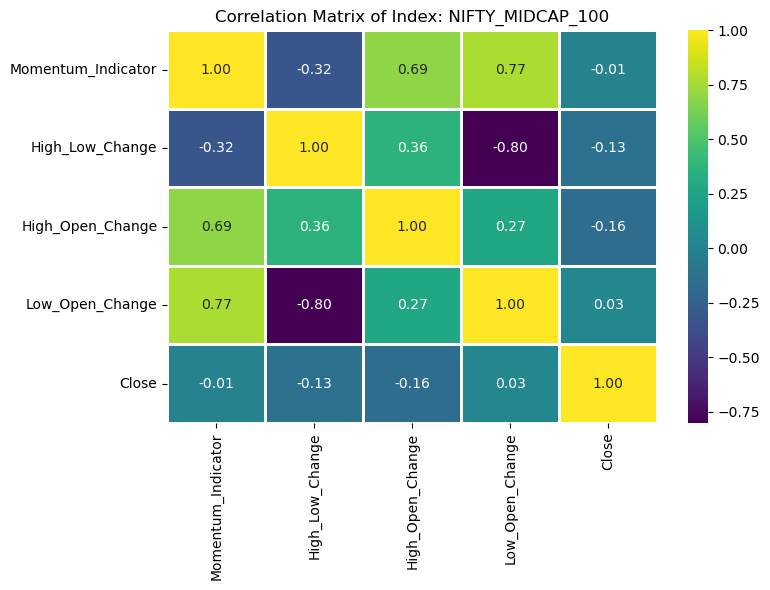


Processing Index: CNXPSUBANK

Index: CNXPSUBANK - Feature Importances:
High_Low_Change       0.280807
Momentum_Indicator    0.273997
Low_Open_Change       0.229329
High_Open_Change      0.215867
dtype: float64


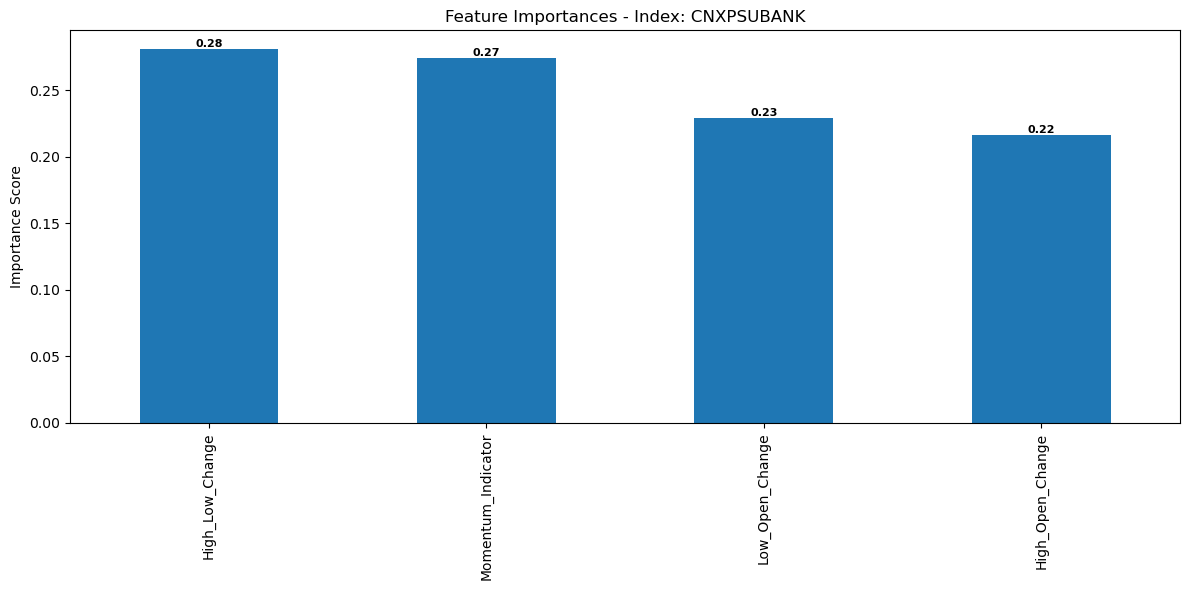

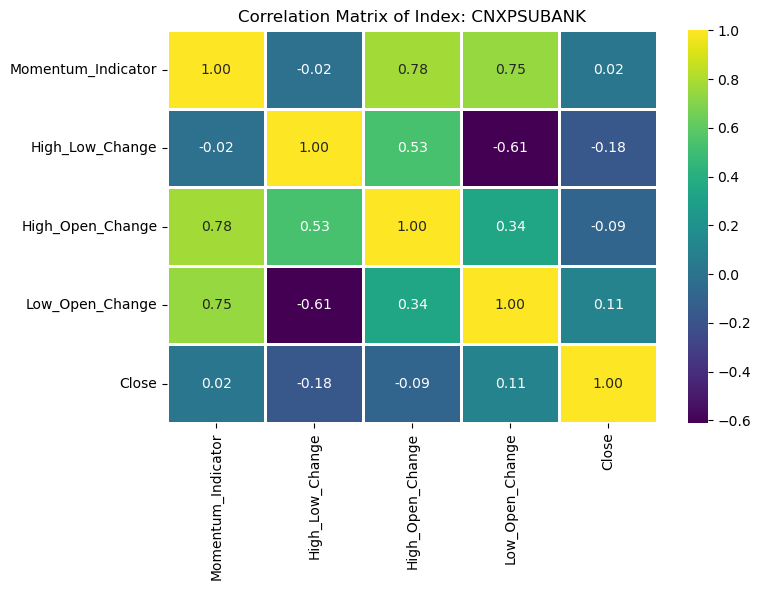


Processing Index: CNXAUTO

Index: CNXAUTO - Feature Importances:
Low_Open_Change       0.269731
Momentum_Indicator    0.260901
High_Low_Change       0.235103
High_Open_Change      0.234264
dtype: float64


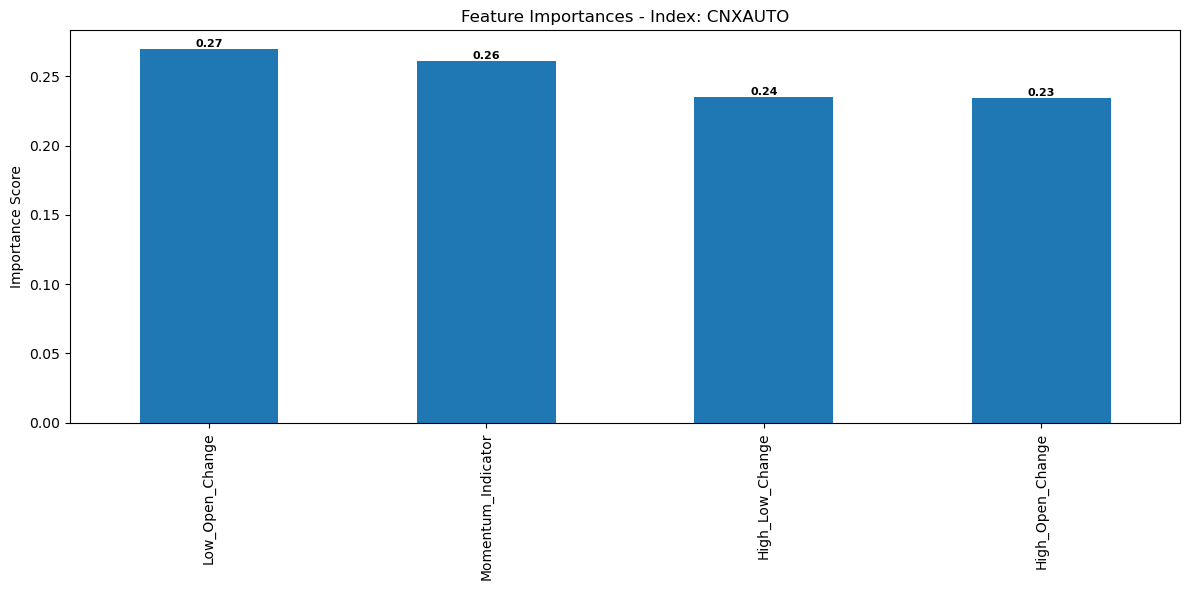

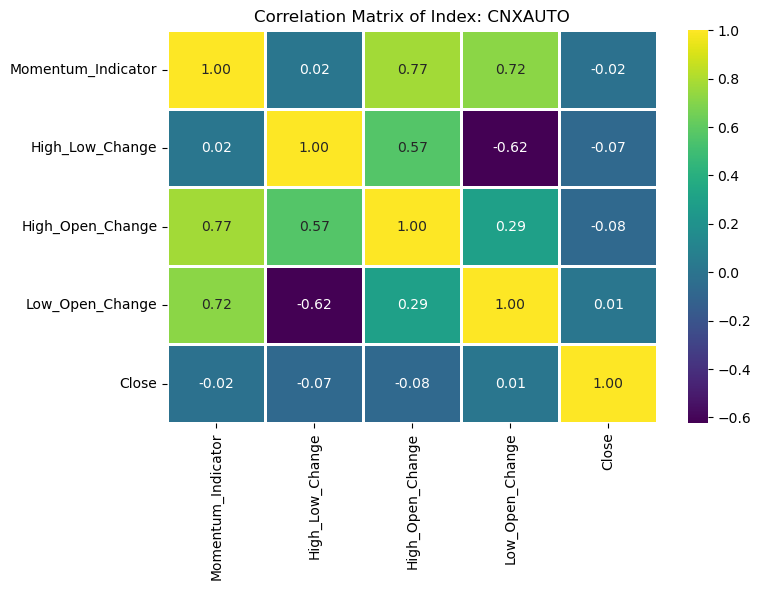


Processing Index: NIFTY_FIN_SERVICE

Index: NIFTY_FIN_SERVICE - Feature Importances:
Low_Open_Change       0.266954
Momentum_Indicator    0.263470
High_Low_Change       0.248167
High_Open_Change      0.221409
dtype: float64


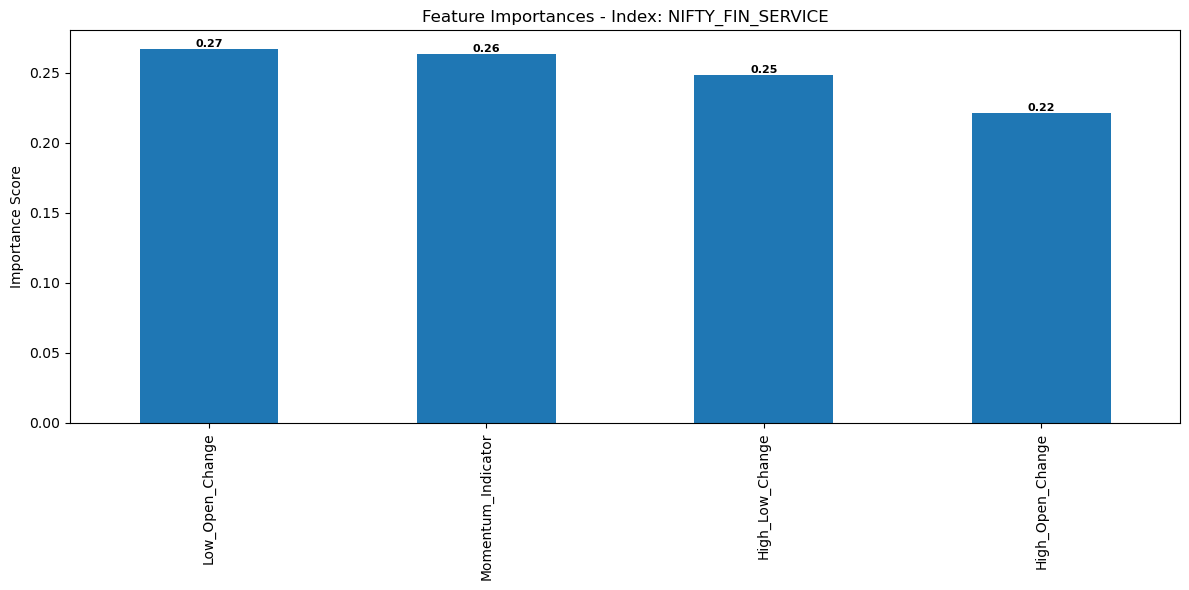

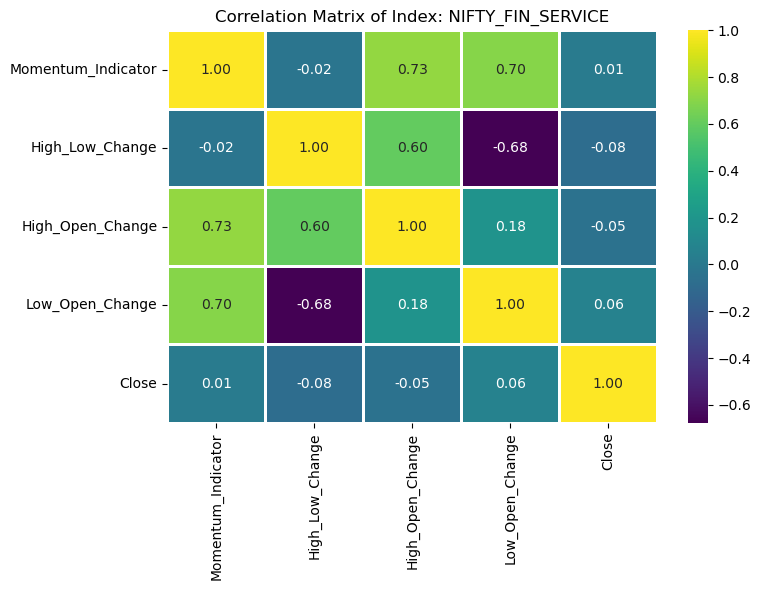

Low_Open_Change       0.266954
Momentum_Indicator    0.263470
High_Low_Change       0.248167
High_Open_Change      0.221409
dtype: float64

In [4]:
index_excel_file = '../Data/Index_Data.xlsx'
all_indexes = pd.read_excel(index_excel_file, sheet_name=None)

print("### Feature Selection for Each Index ###")
for sheet_name, df in all_indexes.items():
    asset_identifier = f"Index: {sheet_name}"
    print(f"\nProcessing {asset_identifier}")
    feat_imp = select_features_rf(df, asset_name=asset_identifier)
    
feat_imp

### Feature Selection for Mutual Funds

### Feature Selection for Each Mutual Fund ###

Processing Mutual Fund: 0P00005WL6

Mutual Fund: 0P00005WL6 - Feature Importances:
Momentum_Indicator    0.0
High_Low_Change       0.0
High_Open_Change      0.0
Low_Open_Change       0.0
dtype: float64


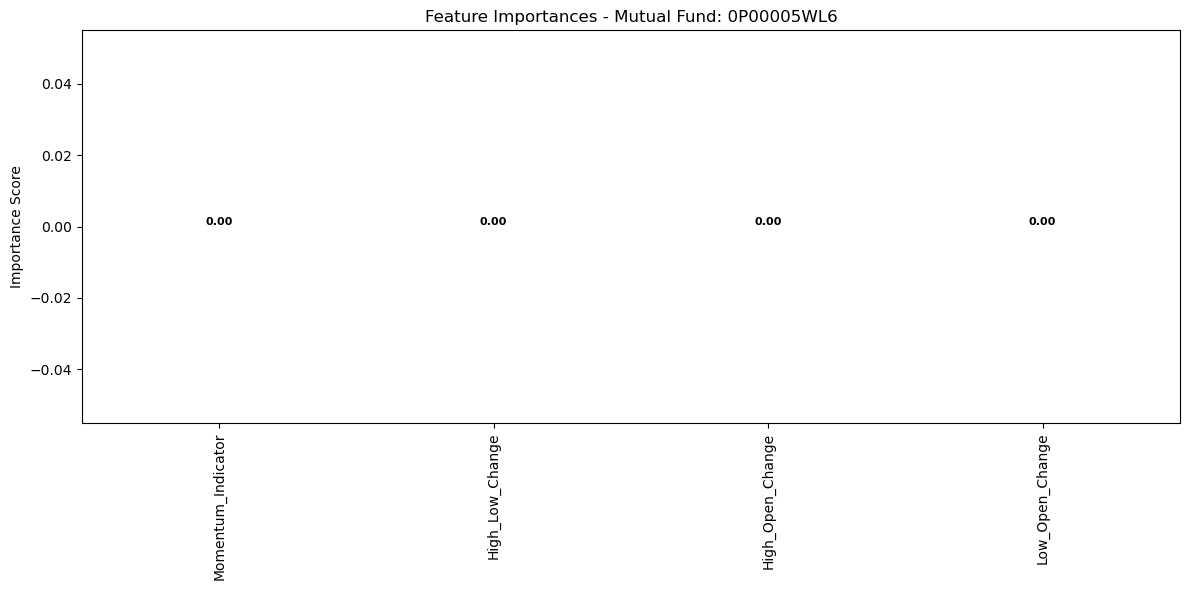

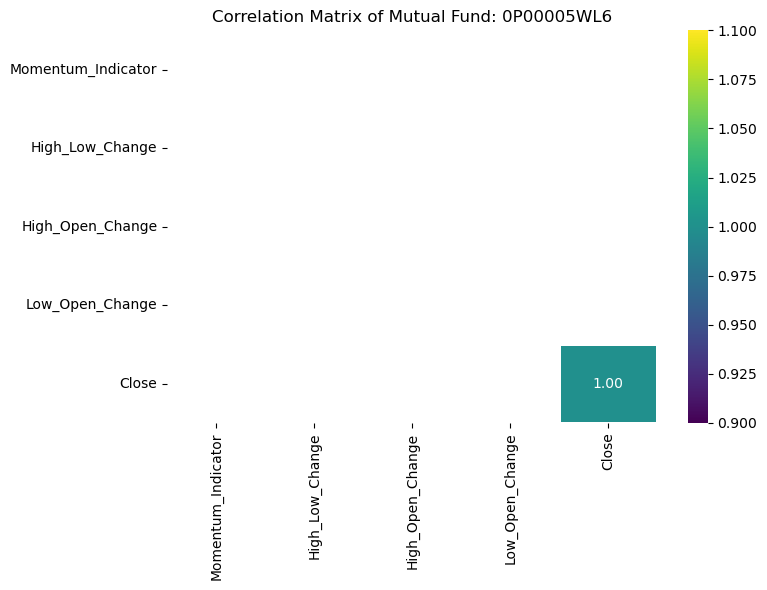


Processing Mutual Fund: UTINEXT50

Mutual Fund: UTINEXT50 - Feature Importances:
High_Low_Change       0.361857
Momentum_Indicator    0.269900
High_Open_Change      0.196770
Low_Open_Change       0.171473
dtype: float64


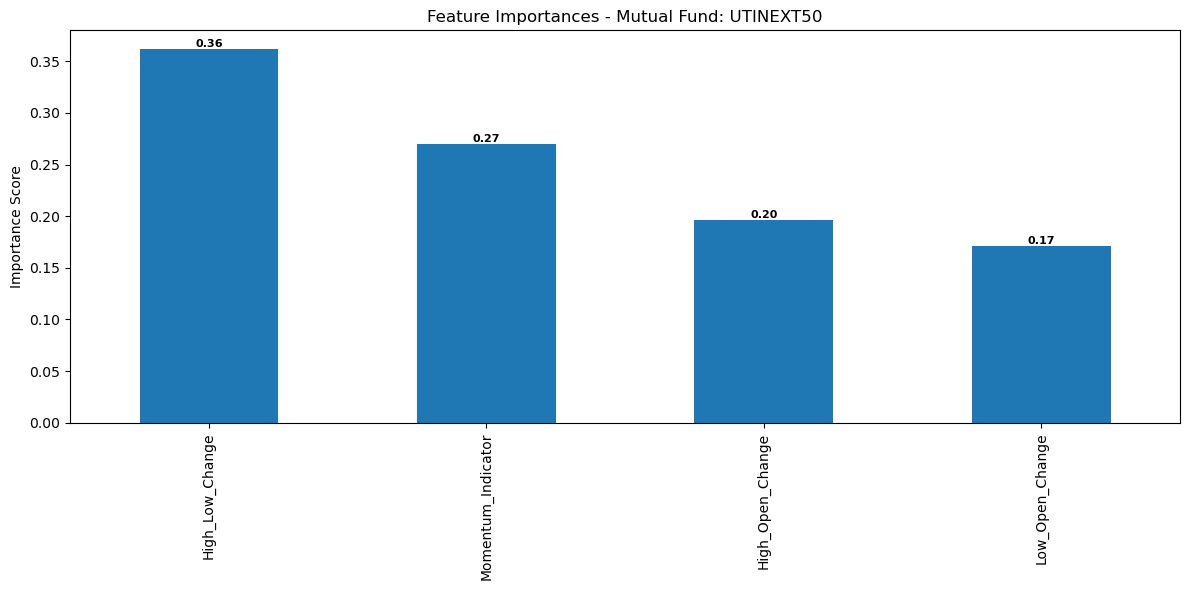

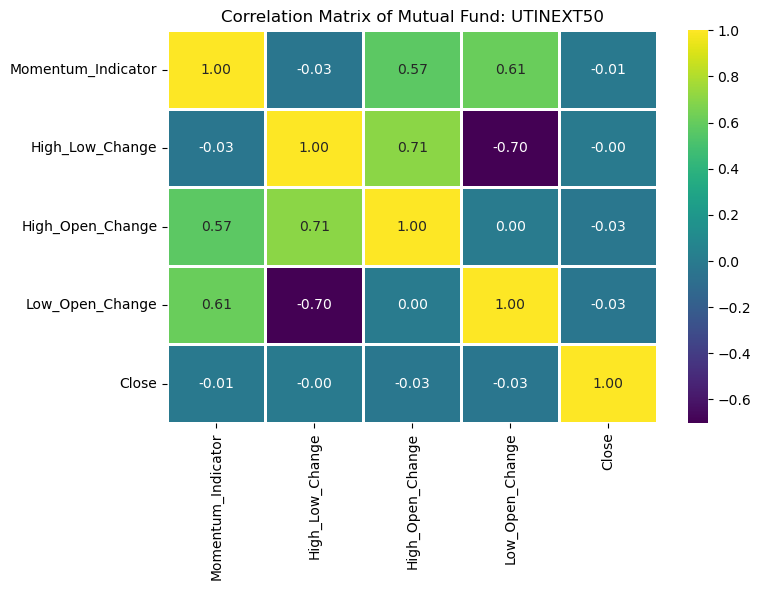


Processing Mutual Fund: 0P0000MLHH

Mutual Fund: 0P0000MLHH - Feature Importances:
Momentum_Indicator    0.0
High_Low_Change       0.0
High_Open_Change      0.0
Low_Open_Change       0.0
dtype: float64


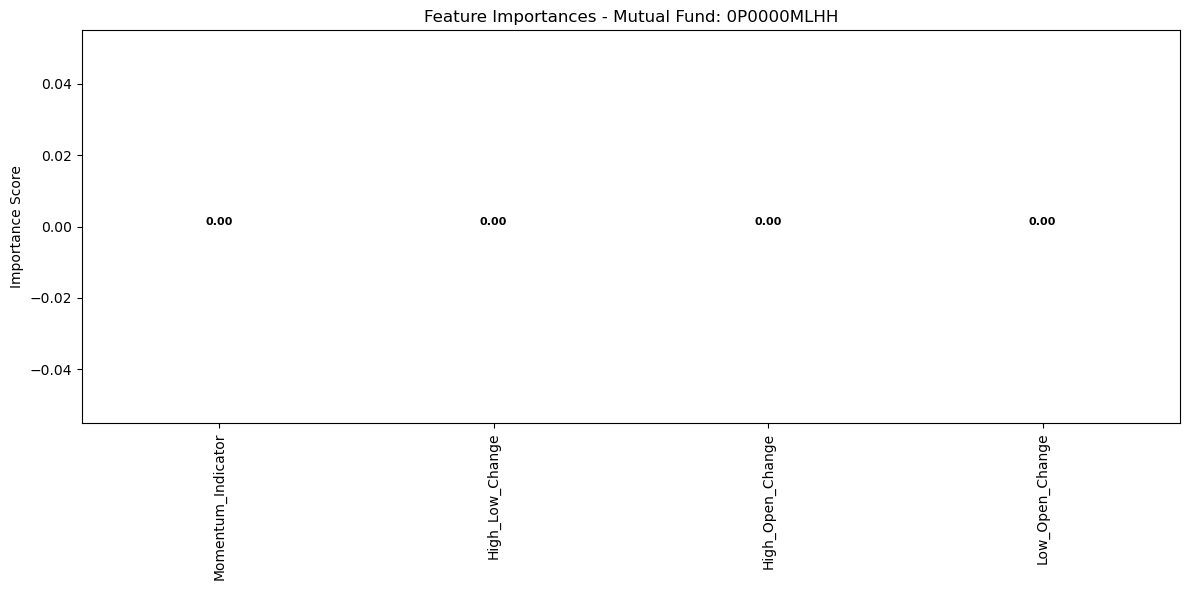

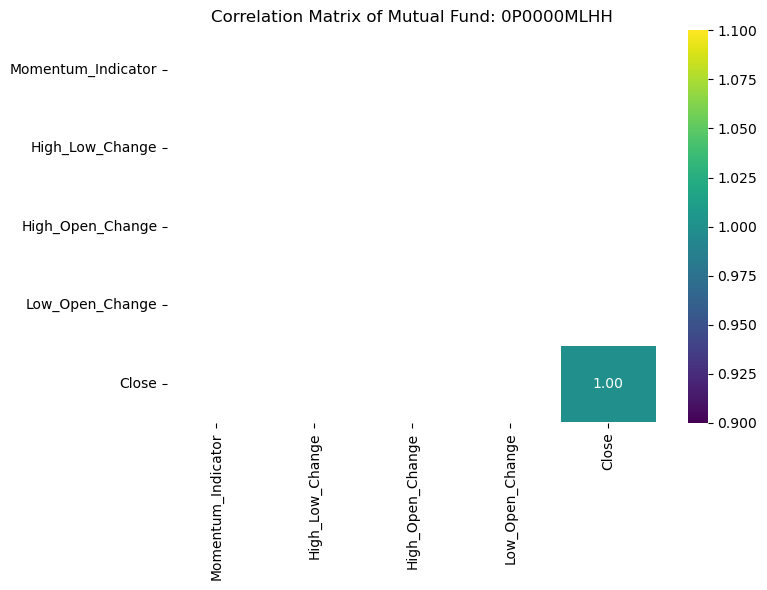


Processing Mutual Fund: 0P0000KV39

Mutual Fund: 0P0000KV39 - Feature Importances:
Momentum_Indicator    0.0
High_Low_Change       0.0
High_Open_Change      0.0
Low_Open_Change       0.0
dtype: float64


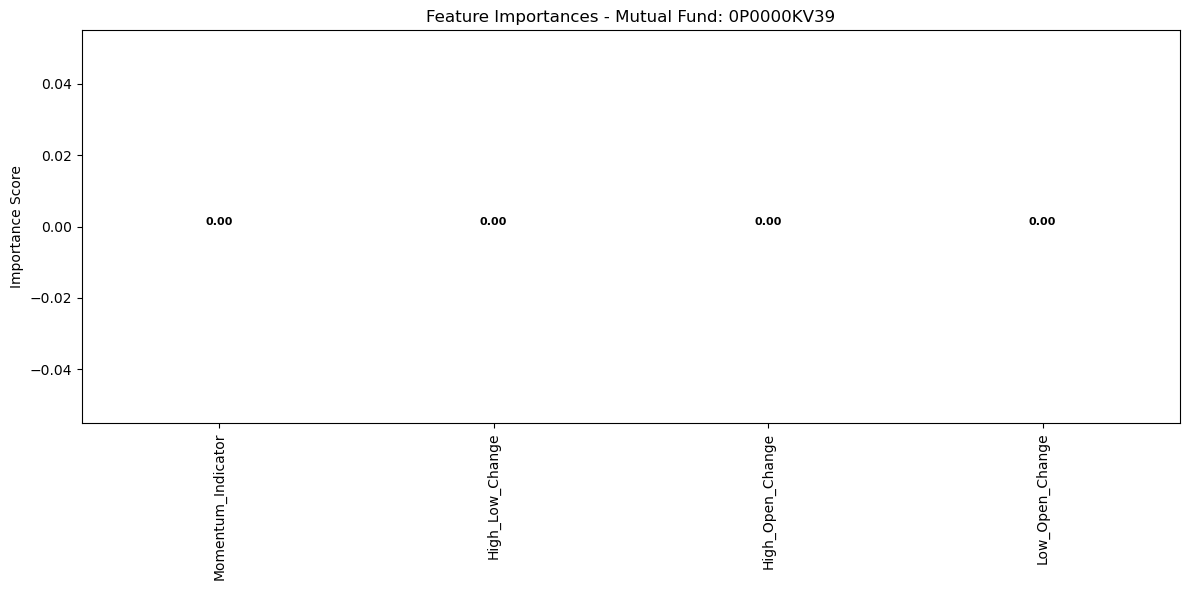

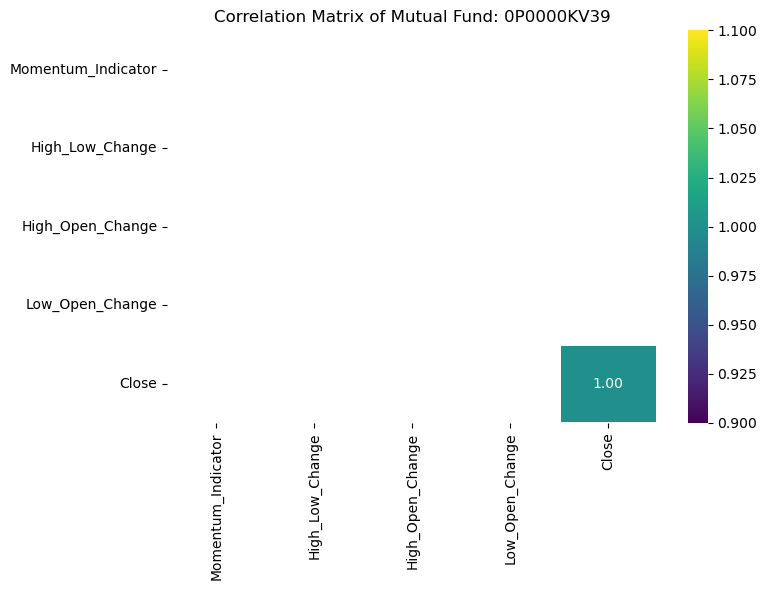


Processing Mutual Fund: 0P00009J3K

Mutual Fund: 0P00009J3K - Feature Importances:
Momentum_Indicator    0.0
High_Low_Change       0.0
High_Open_Change      0.0
Low_Open_Change       0.0
dtype: float64


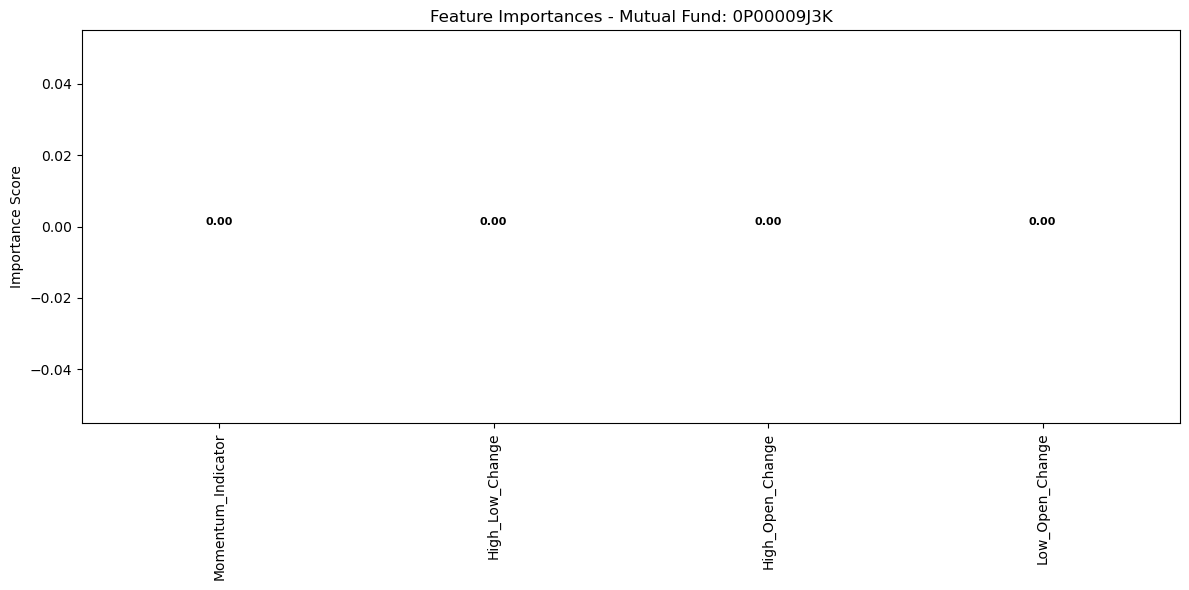

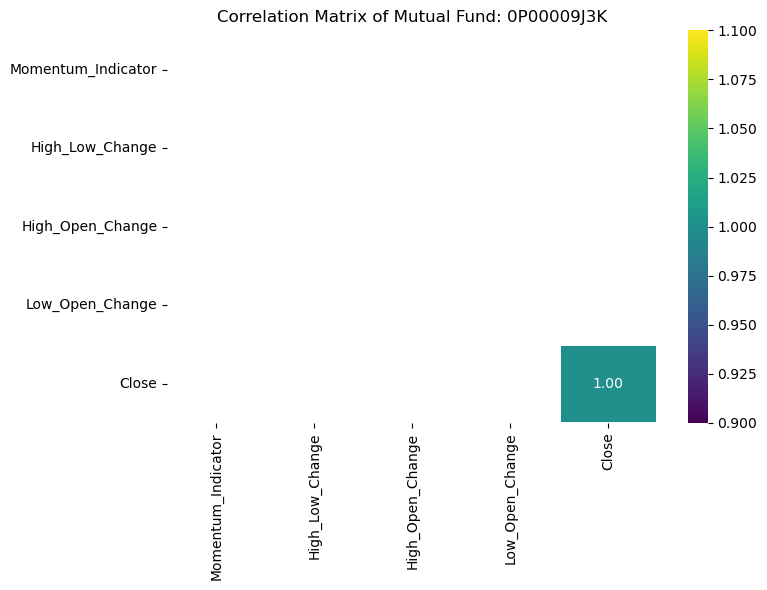


Processing Mutual Fund: 0P0001BAB5

Mutual Fund: 0P0001BAB5 - Feature Importances:
Momentum_Indicator    0.0
High_Low_Change       0.0
High_Open_Change      0.0
Low_Open_Change       0.0
dtype: float64


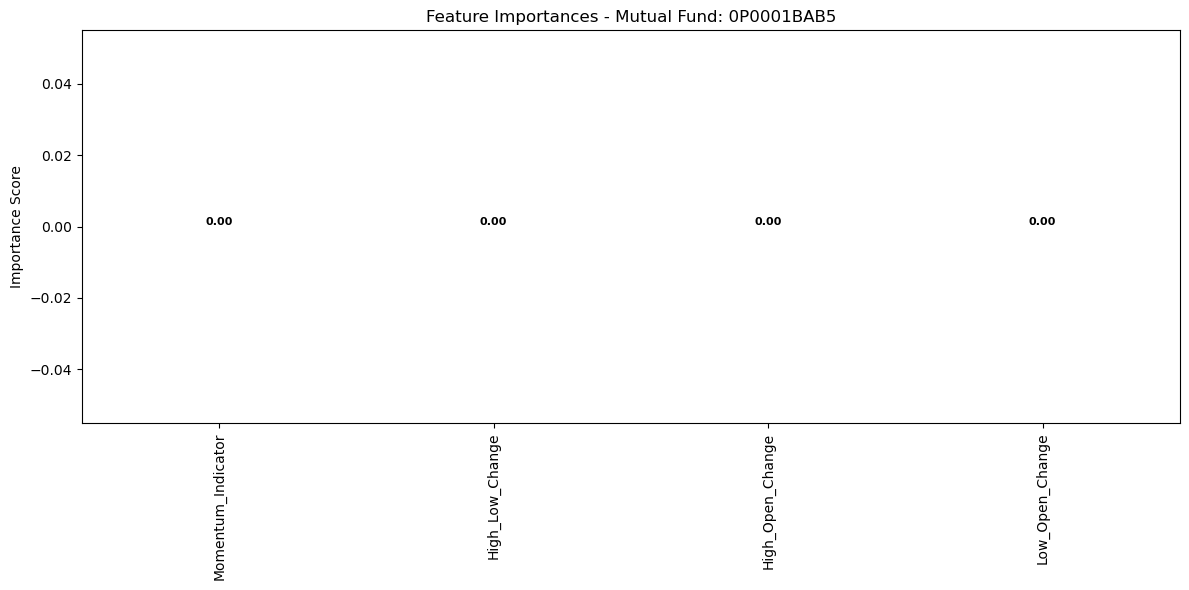

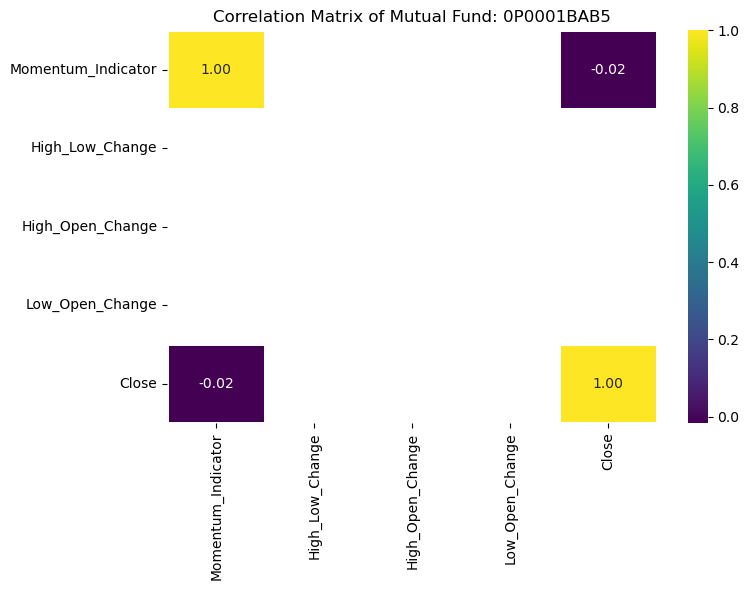


Processing Mutual Fund: 0P0001EI18

Mutual Fund: 0P0001EI18 - Feature Importances:
Momentum_Indicator    0.0
High_Low_Change       0.0
High_Open_Change      0.0
Low_Open_Change       0.0
dtype: float64


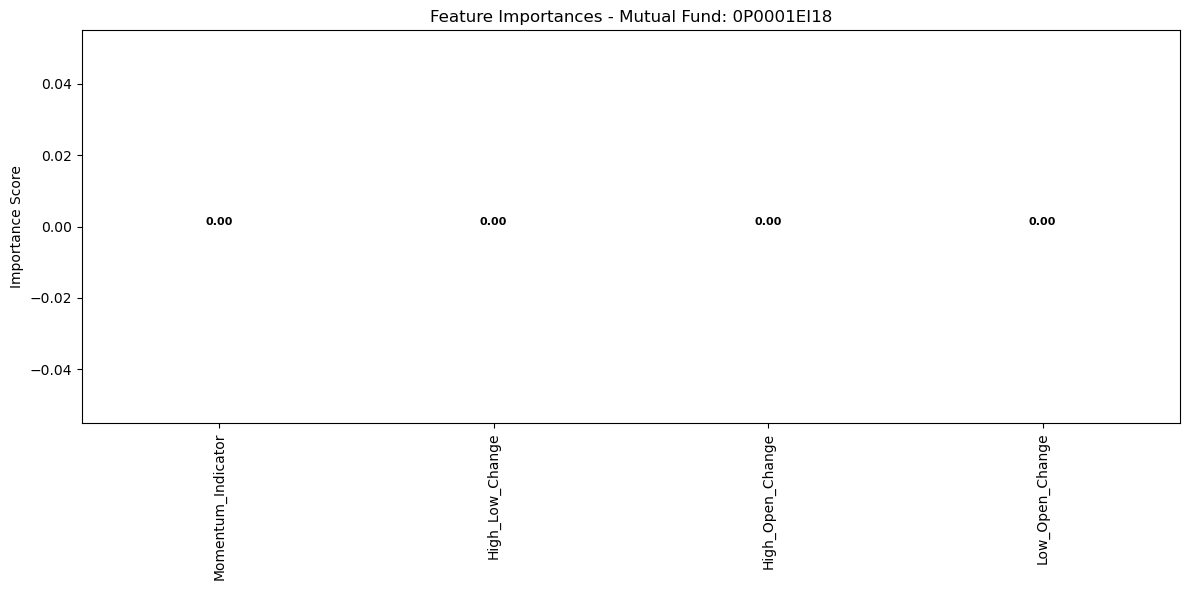

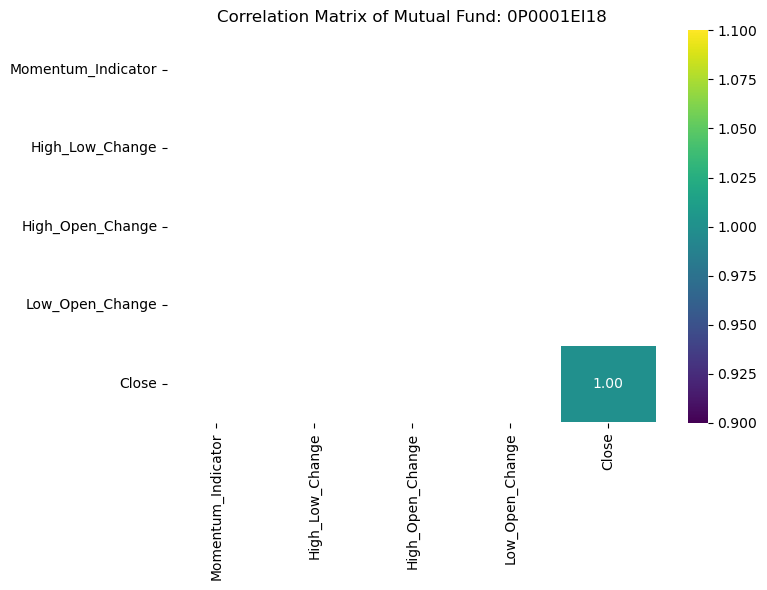


Processing Mutual Fund: 0P0001BA1R

Mutual Fund: 0P0001BA1R - Feature Importances:
Momentum_Indicator    0.0
High_Low_Change       0.0
High_Open_Change      0.0
Low_Open_Change       0.0
dtype: float64


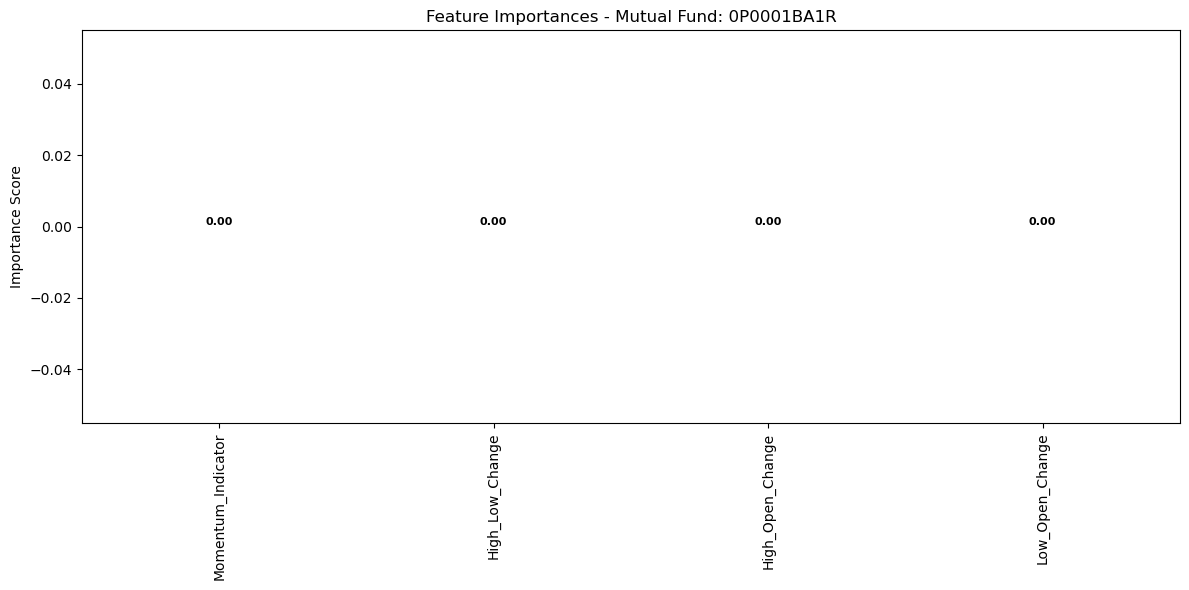

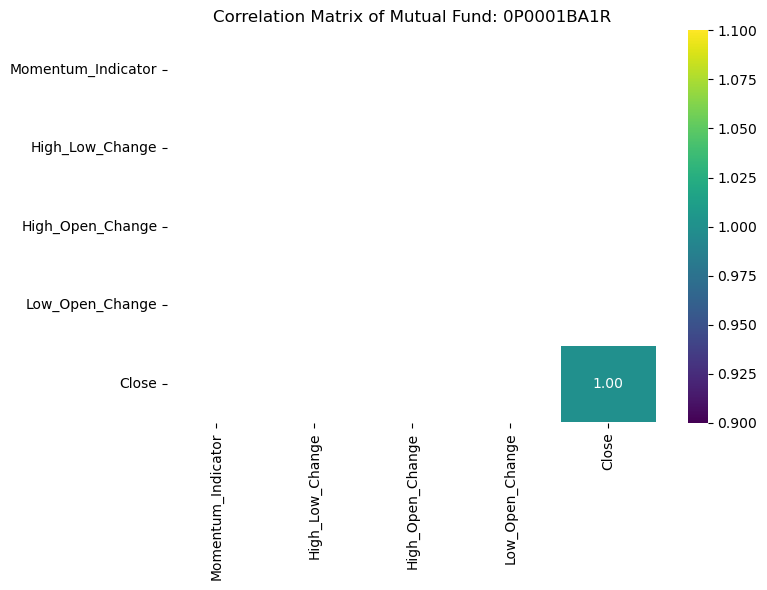


Processing Mutual Fund: 0P00005WEY

Mutual Fund: 0P00005WEY - Feature Importances:
Momentum_Indicator    0.0
High_Low_Change       0.0
High_Open_Change      0.0
Low_Open_Change       0.0
dtype: float64


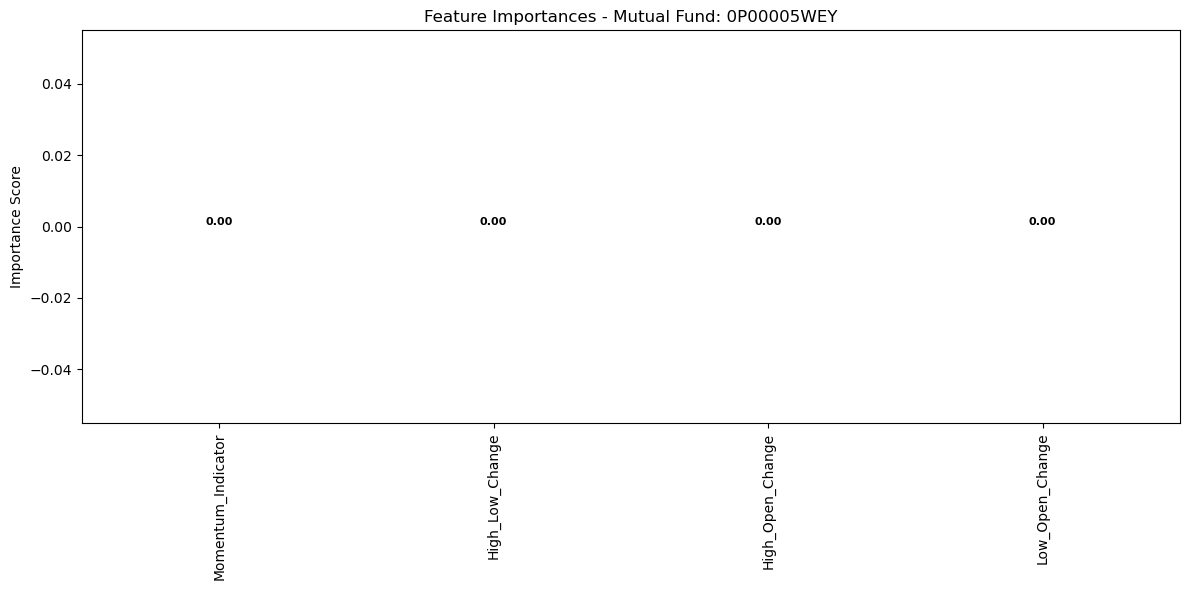

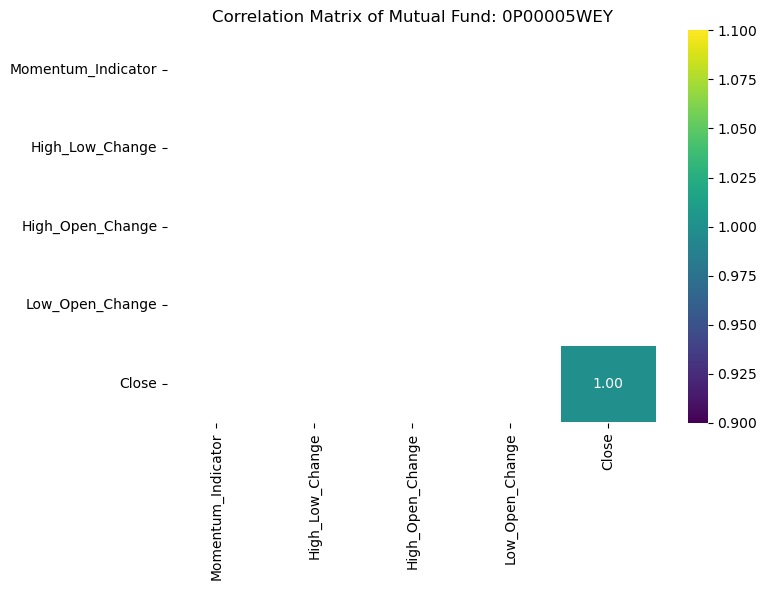


Processing Mutual Fund: 0P0000XUXL

Mutual Fund: 0P0000XUXL - Feature Importances:
Momentum_Indicator    0.0
High_Low_Change       0.0
High_Open_Change      0.0
Low_Open_Change       0.0
dtype: float64


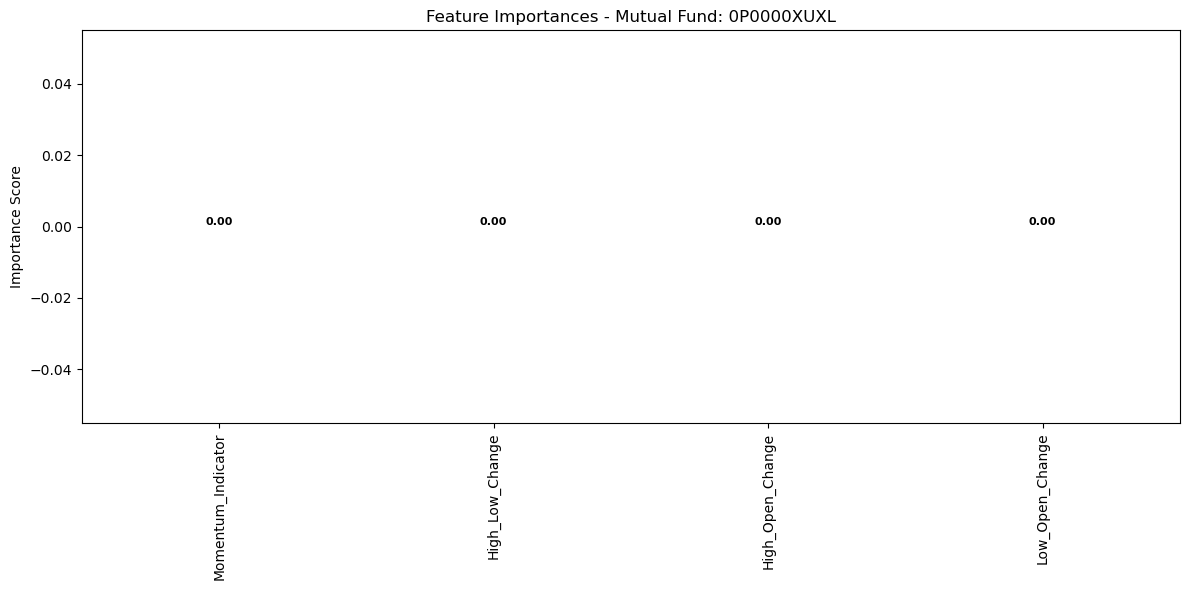

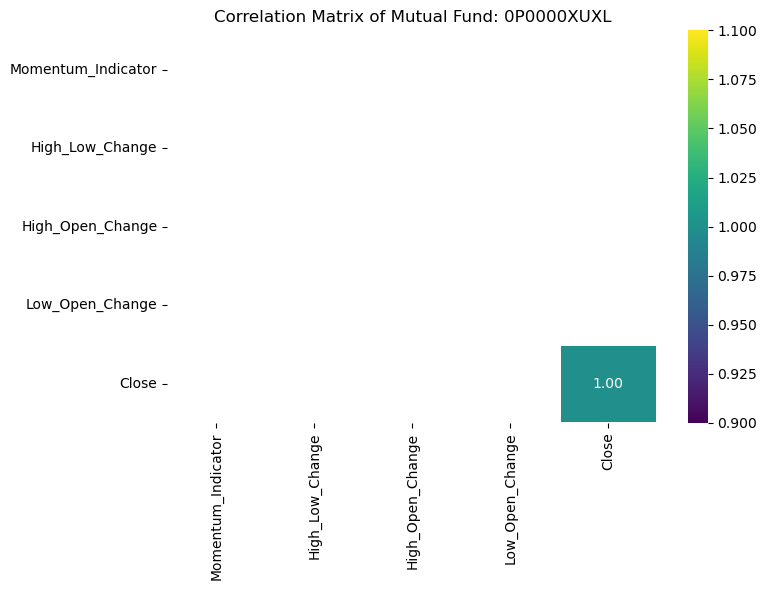


Processing Mutual Fund: 0P0000XUYZ

Mutual Fund: 0P0000XUYZ - Feature Importances:
Momentum_Indicator    0.0
High_Low_Change       0.0
High_Open_Change      0.0
Low_Open_Change       0.0
dtype: float64


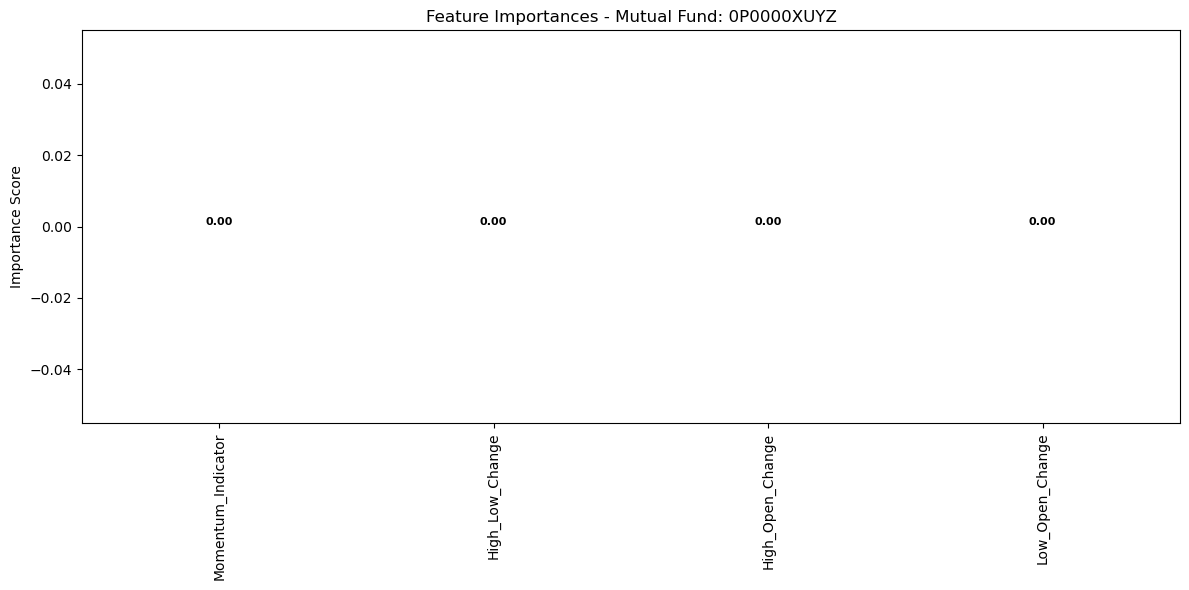

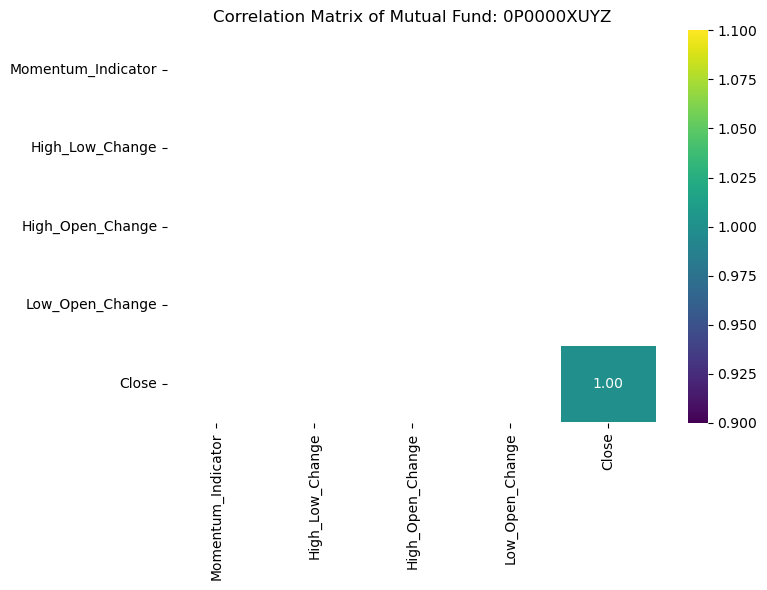


Processing Mutual Fund: 0P0000XW8D

Mutual Fund: 0P0000XW8D - Feature Importances:
Momentum_Indicator    0.0
High_Low_Change       0.0
High_Open_Change      0.0
Low_Open_Change       0.0
dtype: float64


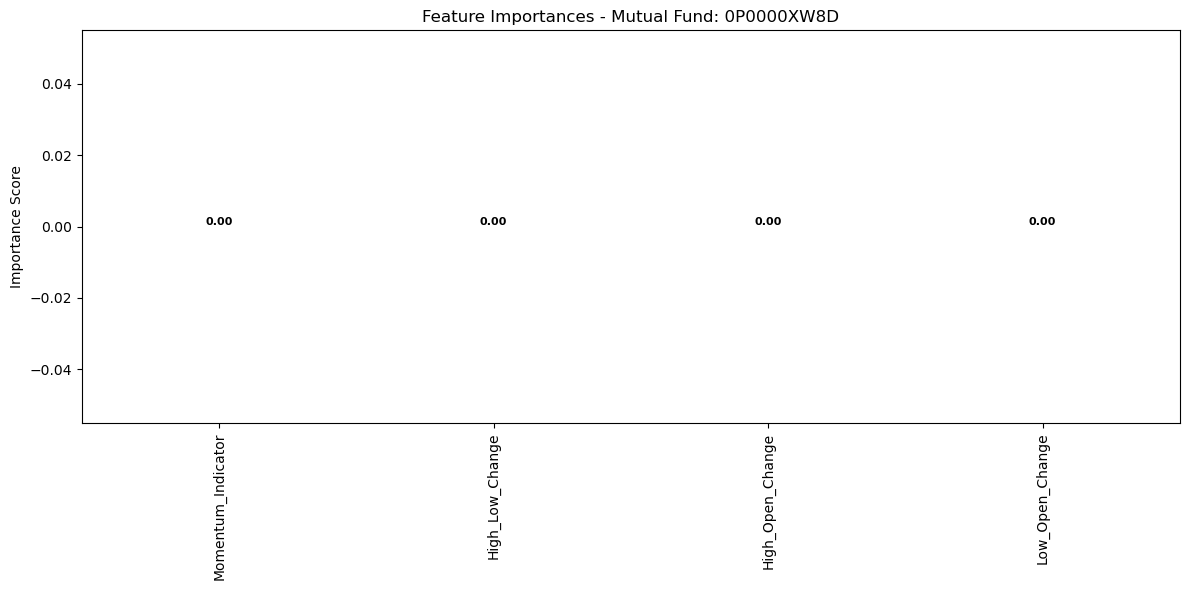

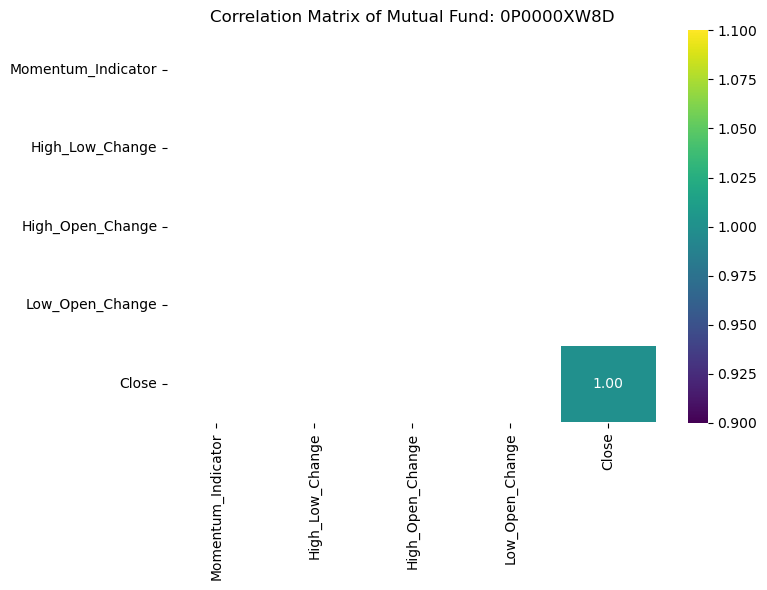


Processing Mutual Fund: 0P0000XVER

Mutual Fund: 0P0000XVER - Feature Importances:
Momentum_Indicator    0.0
High_Low_Change       0.0
High_Open_Change      0.0
Low_Open_Change       0.0
dtype: float64


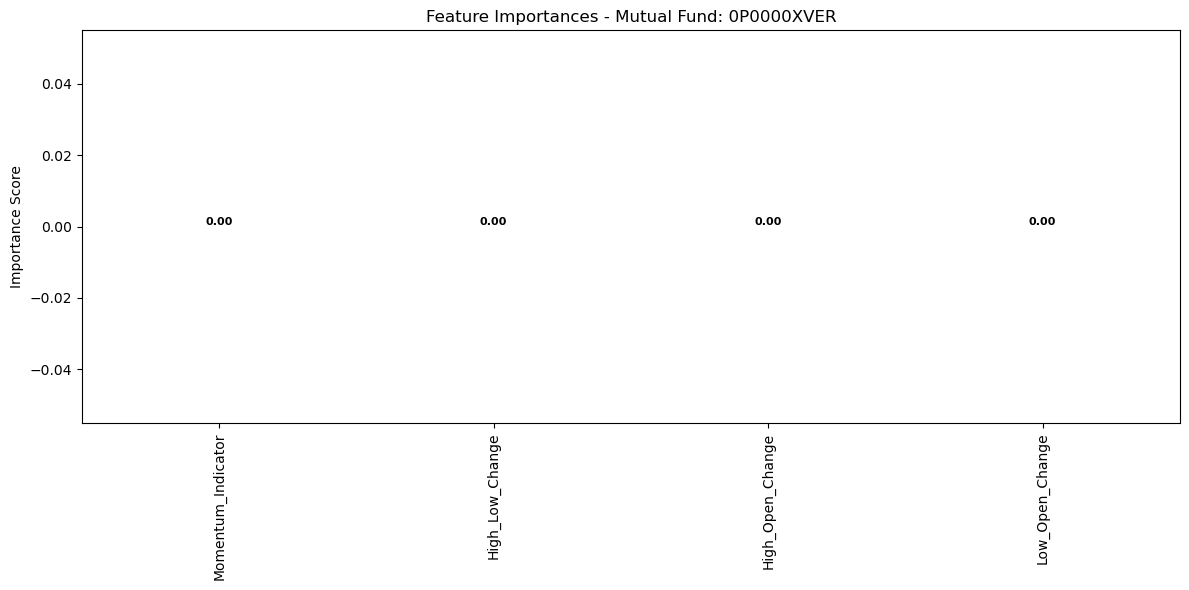

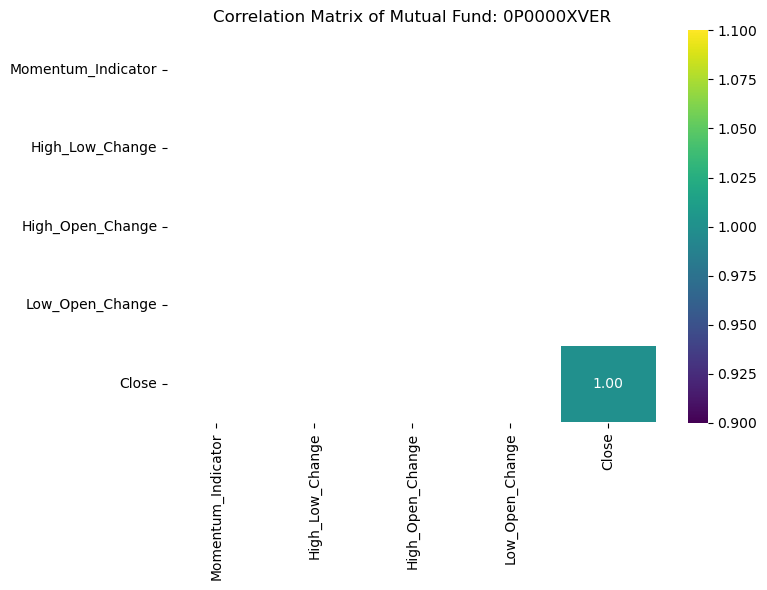


Processing Mutual Fund: 0P0000XUYS

Mutual Fund: 0P0000XUYS - Feature Importances:
Momentum_Indicator    0.0
High_Low_Change       0.0
High_Open_Change      0.0
Low_Open_Change       0.0
dtype: float64


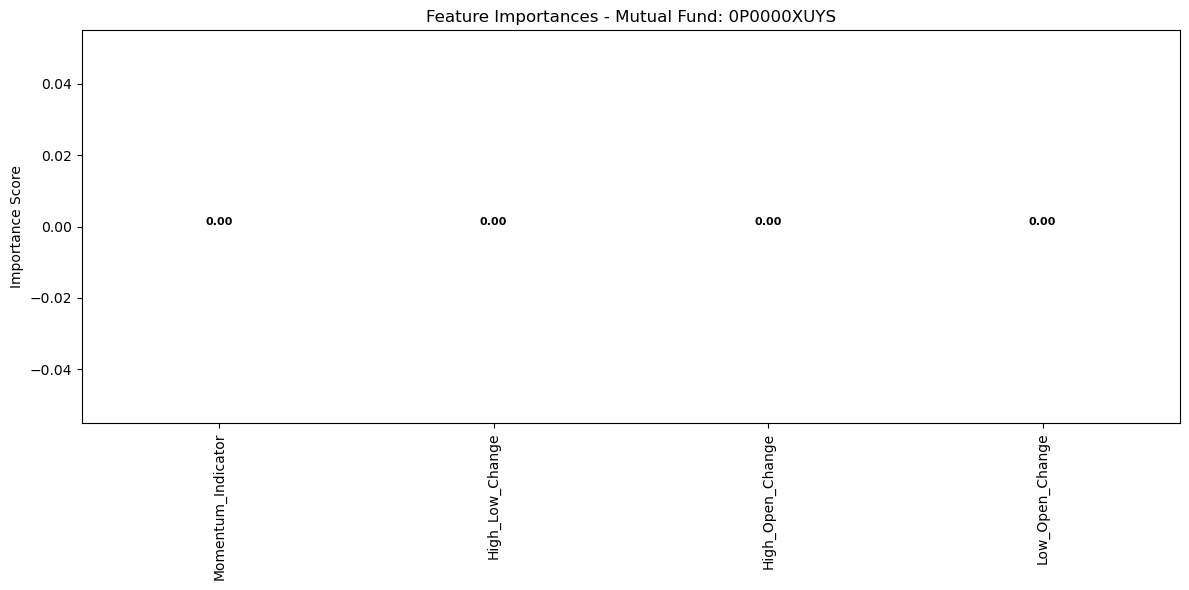

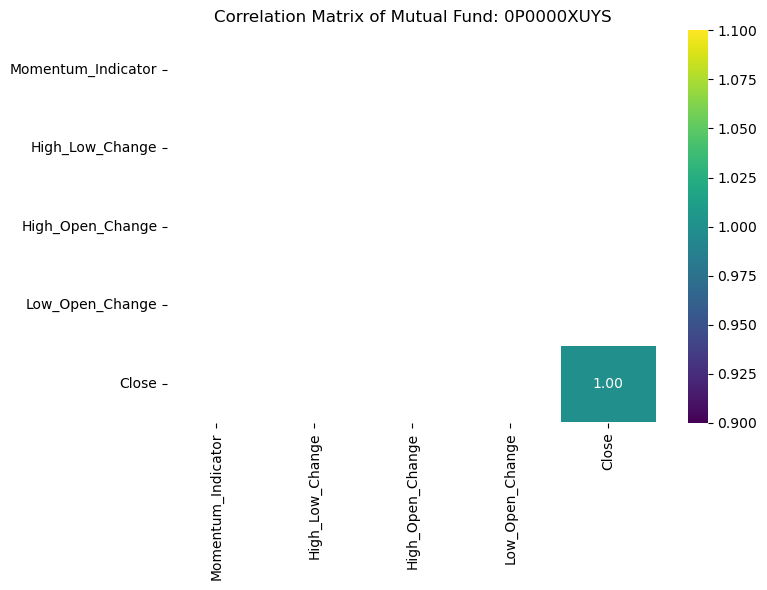


Processing Mutual Fund: 0P0000XW7I

Mutual Fund: 0P0000XW7I - Feature Importances:
Momentum_Indicator    0.0
High_Low_Change       0.0
High_Open_Change      0.0
Low_Open_Change       0.0
dtype: float64


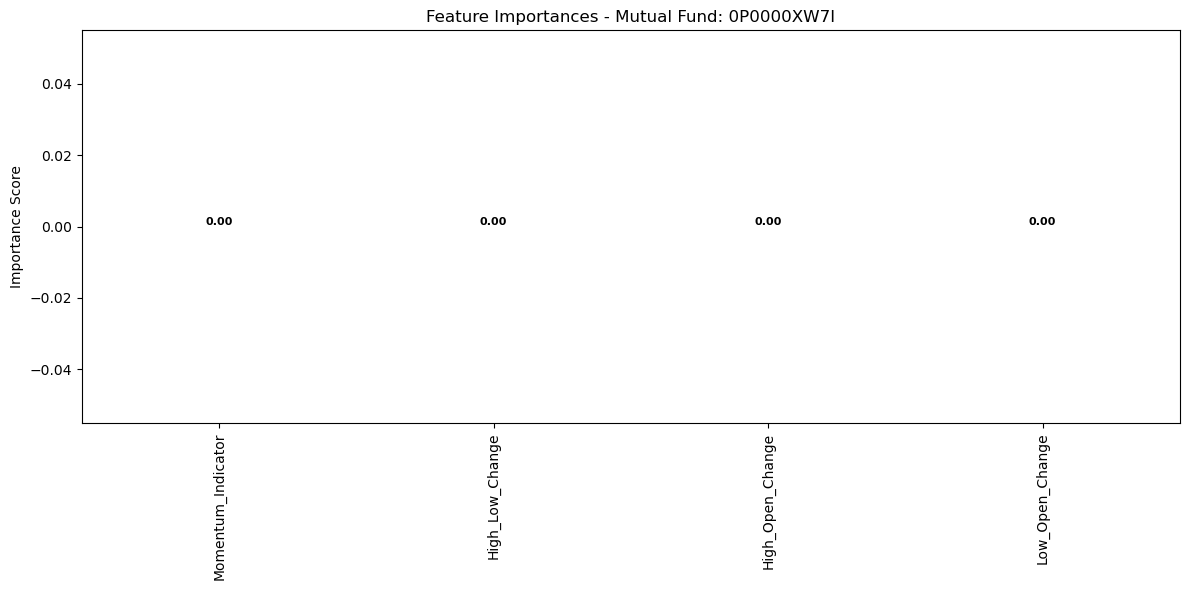

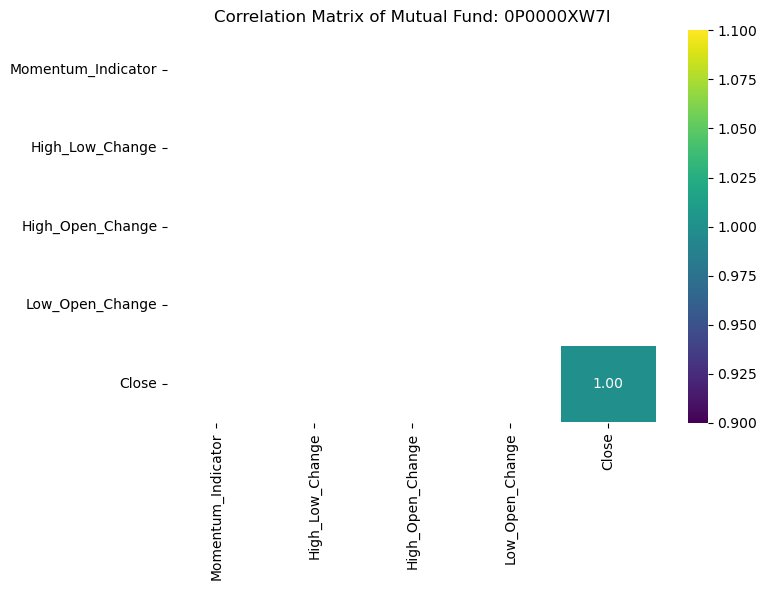


Processing Mutual Fund: 0P0000U3OG

Mutual Fund: 0P0000U3OG - Feature Importances:
Momentum_Indicator    0.0
High_Low_Change       0.0
High_Open_Change      0.0
Low_Open_Change       0.0
dtype: float64


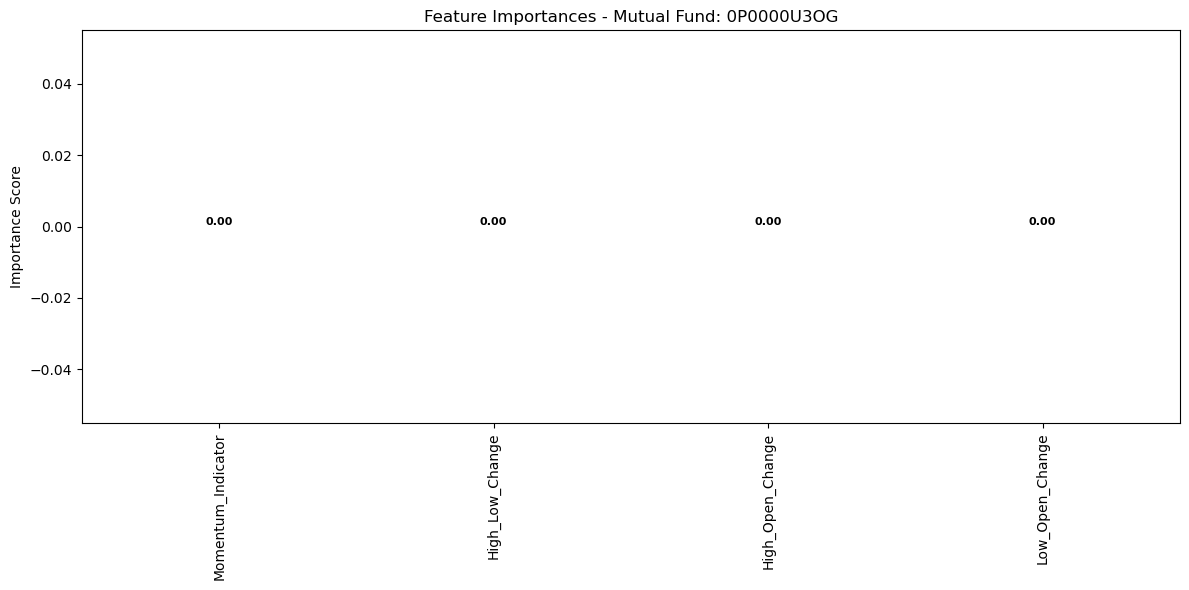

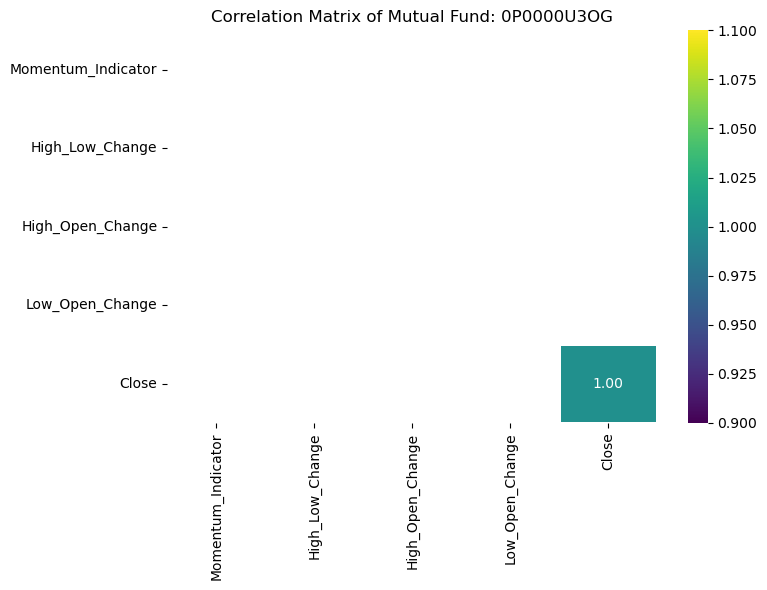


Processing Mutual Fund: SETFGOLD

Mutual Fund: SETFGOLD - Feature Importances:
Momentum_Indicator    0.336039
High_Low_Change       0.282186
Low_Open_Change       0.216396
High_Open_Change      0.165380
dtype: float64


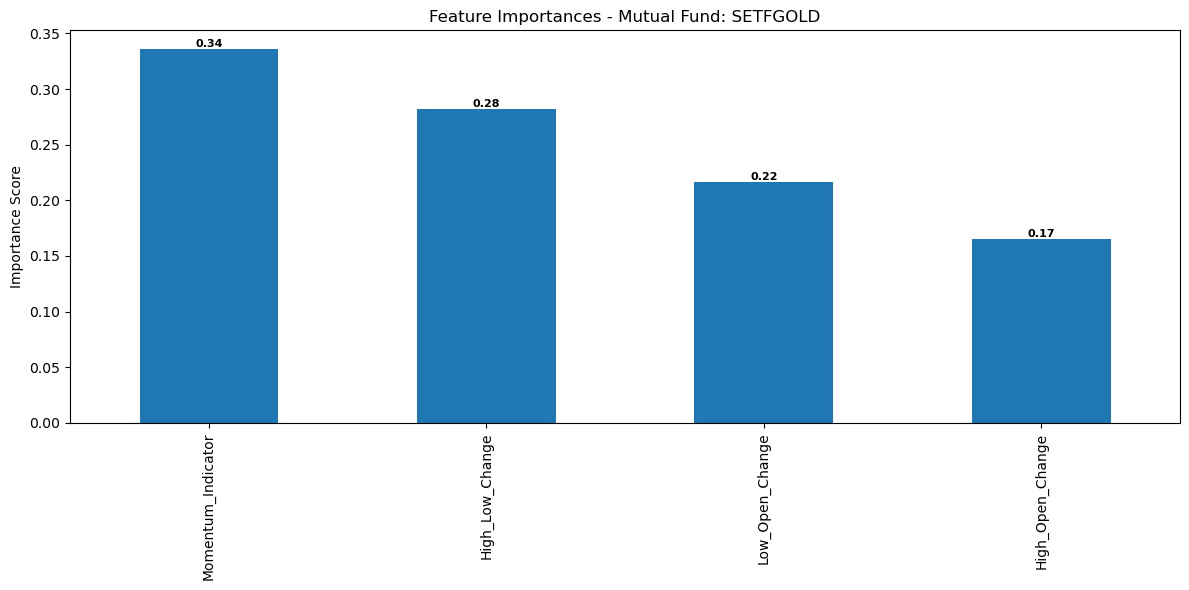

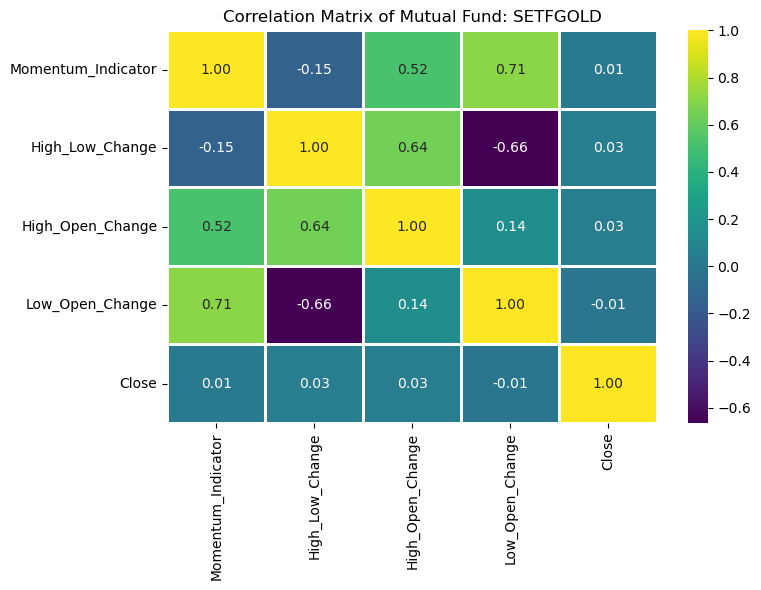


Processing Mutual Fund: BSLGOLDETF

Mutual Fund: BSLGOLDETF - Feature Importances:
Momentum_Indicator    0.346108
High_Low_Change       0.268608
Low_Open_Change       0.230094
High_Open_Change      0.155190
dtype: float64


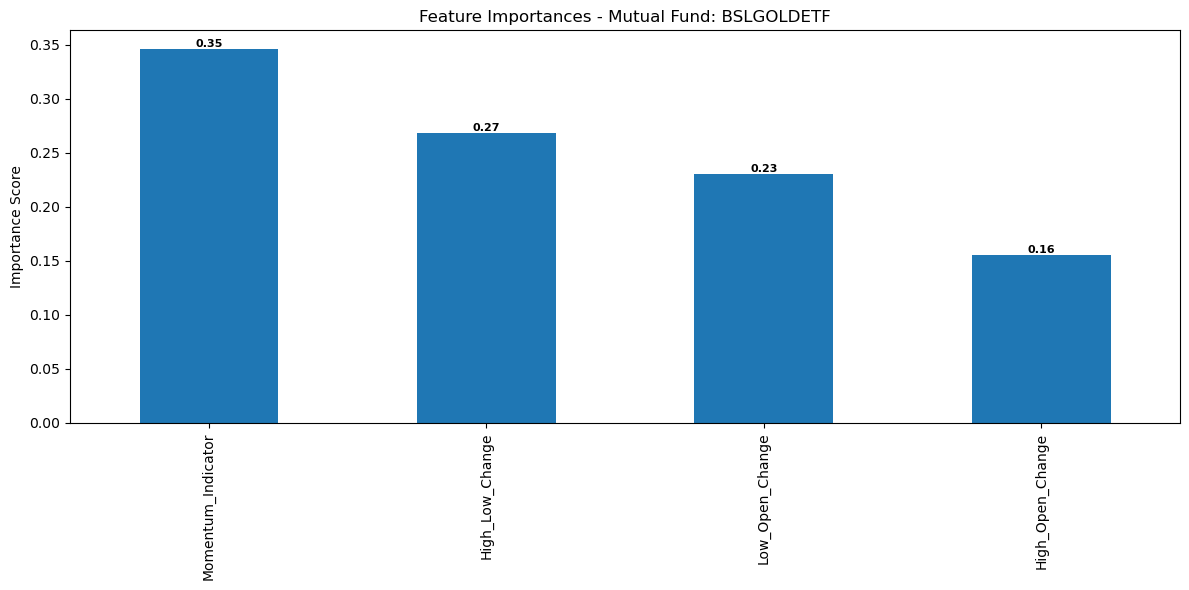

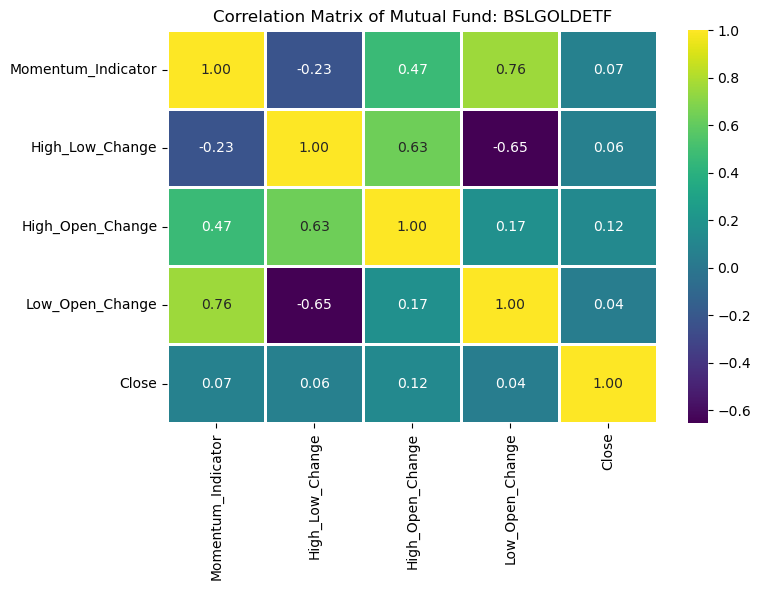

In [5]:
mutual_funds_excel_file = '../Data/Mutual_Funds_Data.xlsx'
all_mutual_funds = pd.read_excel(mutual_funds_excel_file, sheet_name=None)

print("### Feature Selection for Each Mutual Fund ###")
for sheet_name, df in all_mutual_funds.items():
    asset_identifier = f"Mutual Fund: {sheet_name}"
    print(f"\nProcessing {asset_identifier}")
    feat_imp = select_features_rf(df, asset_name=asset_identifier)

### Feature Selection for Gold Bonds

### Feature Selection for Gold Bonds ###

Gold Bonds - Feature Importances:
Momentum_Indicator    0.393185
High_Low_Change       0.289411
Low_Open_Change       0.161648
High_Open_Change      0.155756
dtype: float64


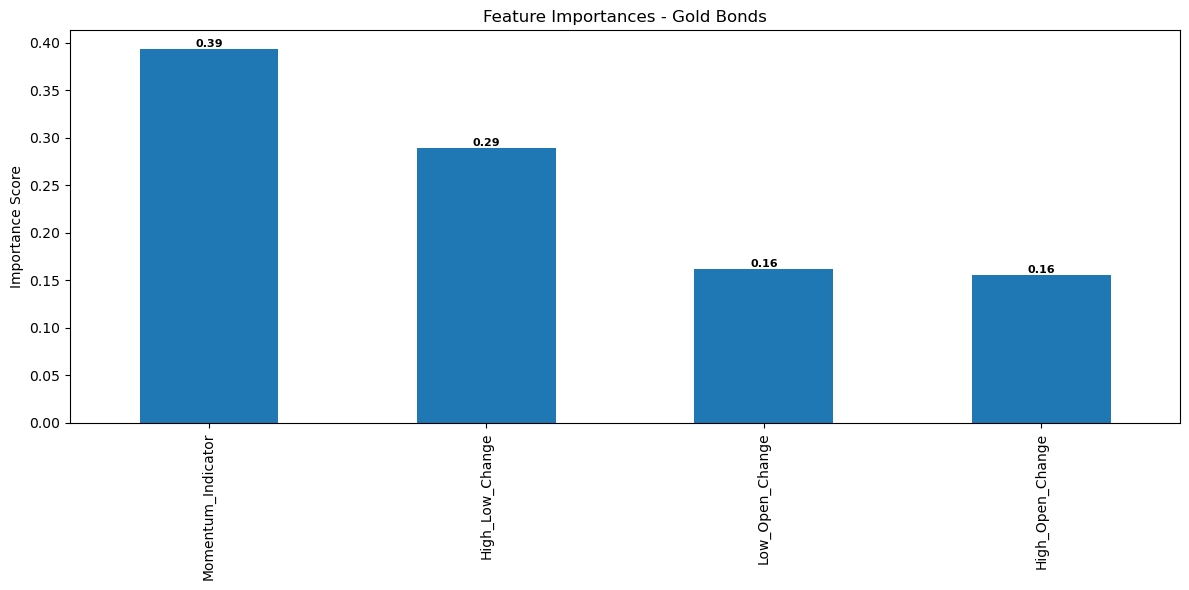

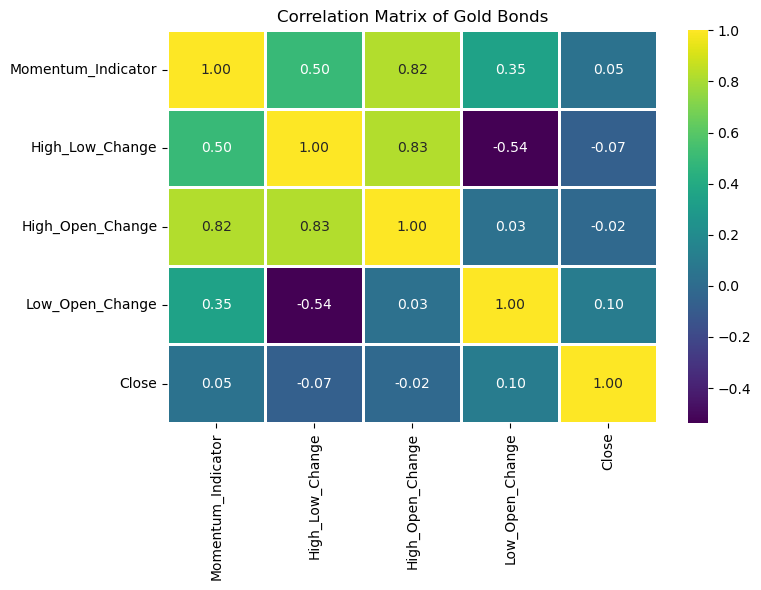

In [6]:
gold_bonds_file = '../Data/Gold_Bond_Data.xlsx'
gold_df = pd.read_excel(gold_bonds_file)

print("### Feature Selection for Gold Bonds ###")
feat_imp_gold = select_features_rf(gold_df, asset_name="Gold Bonds")